In [4]:
import mxnet as mx
import numpy as np
import scipy as sp
import sys
import networkx as nx
import igraph as ig
import logging
import time
import matplotlib.pyplot as plt
import math

In [47]:
def get_act(act):
    if (act == 'sigmoid'):
        return sp.special.expit
    elif (act == 'tanh'):
        return np.tanh
    elif (act == 'relu'):
        return lambda x: np.maximum(x, 0)
    else:
        return None
    
weight_names = ['fc1_weight', 'fc2_weight']
bias_names = ['fc1_bias', 'fc2_bias']

def SparseSyms(dims):
    data = mx.symbol.Variable('data', stype='csr')
    y = mx.symbol.Variable('label')
    fc1_weight = mx.symbol.Variable(weight_names[0], shape=(dims[0], dims[1]), stype='row_sparse')
    fc1_bias = mx.symbol.Variable(bias_names[0], shape=(dims[1]))
    fc2_weight = mx.symbol.Variable(weight_names[1], shape=(dims[2], dims[1]))
    fc2_bias = mx.symbol.Variable(bias_names[1], shape=(dims[2]))
    return (data, y, fc1_weight, fc1_bias, fc2_weight, fc2_bias)

def DenseSyms(dims):
    data = mx.symbol.Variable('data')
    y = mx.symbol.Variable('label')
    fc1_weight = mx.symbol.Variable(weight_names[0], shape=(dims[1], dims[0]))
    fc1_bias = mx.symbol.Variable(bias_names[0], shape=(dims[1]))
    fc2_weight = mx.symbol.Variable(weight_names[1], shape=(dims[2], dims[1]))
    fc2_bias = mx.symbol.Variable(bias_names[1], shape=(dims[2]))
    return (data, y, fc1_weight, fc1_bias, fc2_weight, fc2_bias)

def SparseFC(data, weight, bias, num_hidden):
    dot = mx.symbol.sparse.dot(data, weight)
    return mx.symbol.broadcast_add(dot, bias)

def DenseFC(data, weight, bias, num_hidden):
    return mx.symbol.FullyConnected(data=data, weight=weight, bias=bias,
                                    num_hidden=num_hidden)

def DenseNumpyFC(data, weight, bias):
    return np.dot(data, weight.T) + bias

def SparseNumpyFC(data, weight, bias):
    return np.dot(data, weight) + bias

def log_loss(x, y):
    return -(y * np.log(x) + (1 - y) * np.log(1 - x))

def logistic_np(x, y):
    return np.sum(log_loss(sp.special.expit(x), y))

def logistic_mx(x, y):
    x = 1/(1+mx.symbol.exp(-x))
    return mx.symbol.sum(-(y * mx.symbol.log(x) + (1 - y) * mx.symbol.log(1 - x)))

def get_loss(name):
    if (name == "L2"):
        l2_numpy = lambda x, y: np.sum(np.square(x - y))
        l2_mx = lambda x, y: mx.symbol.LinearRegressionOutput(data=x, label=y)
        return l2_numpy, l2_mx
    elif (name == "logistic"):
        sm_numpy = logistic_np
        sm_mx = logistic_mx
        return sm_numpy, sm_mx
    else:
        return None

def plot_errors(x, y):
    plt.plot(x, y)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.show()

class AutoEncoderModel:
    def __init__(self, data, y, num_dims, internal_act=None, learning_rate=0.005,
                 batch_size=50, loss_name="L2", proj=None, use_sparse=False):
        dims = [data.shape[1], num_dims, y.shape[1]]
        if (use_sparse):
            print("Use sparse operators")
            CreateSyms = SparseSyms
            FC = SparseFC
            NumpyFC = SparseNumpyFC
        else:
            CreateSyms = DenseSyms
            FC = DenseFC
            NumpyFC = DenseNumpyFC
            
        syms = CreateSyms(dims)
        self.data = syms[0]
        self.y = syms[1];
        self.fc1_weight = syms[2]
        self.fc1_bias = syms[3]
        self.fc2_weight = syms[4]
        self.fc2_bias = syms[5]
        x = FC(data=self.data, weight=self.fc1_weight, bias=self.fc1_bias, num_hidden=dims[1])
        if (internal_act is not None):
            x = mx.symbol.Activation(data=x, act_type=internal_act)
            print("Internal activation: " + internal_act)
        self.layer1 = x
        x = DenseFC(data=x, weight=self.fc2_weight, bias=self.fc2_bias, num_hidden=dims[2])
        self.layer2 = x
        print("loss func: " + loss_name)
        np_loss, mx_loss = get_loss(loss_name)
        # TODO How about using L1/L2 regularization.
        self.loss = mx_loss(x, self.y)
        self.model = mx.mod.Module(symbol=self.loss, data_names=['data'], label_names = ['label'])
        self.init_data(data, y, batch_size, learning_rate)
        
        def cal_model_numpy(params):
            fc1_weight = params.get(weight_names[0]).asnumpy()
            fc1_bias = params.get(bias_names[0]).asnumpy()
            fc2_weight = params.get(weight_names[1]).asnumpy()
            fc2_bias = params.get(bias_names[1]).asnumpy()

            np_data = data.asnumpy()
            hidden = NumpyFC(np_data, fc1_weight, fc1_bias)
            act_func = get_act(internal_act)
            if (act_func is not None):
                hidden = act_func(hidden)
            output = DenseNumpyFC(hidden, fc2_weight, fc2_bias)
            if (proj is not None):
                output = np.dot(output, proj)
            return np_loss(output, np_data)

        self.numpy_cal = cal_model_numpy
        
    def init_data(self, data, y, batch_size=50, learning_rate=0.005):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':y},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        print("Learning rate: " + str(learning_rate))
        print("batch size: " + str(batch_size))
        # allocate memory given the input data and label shapes
        self.model.bind(data_shapes=data_iter.provide_data, label_shapes=data_iter.provide_label)
        # initialize parameters by uniform random numbers
        self.model.init_params(initializer=mx.init.Uniform(scale=.1))
        # use SGD with learning rate 0.1 to train
        self.model.init_optimizer(optimizer='sgd',
                                  optimizer_params={'learning_rate': learning_rate,
                                                    'momentum': 0.9})

    def fit_int(self, data, y, batch_size, num_epoch, params=None, learning_rate=0.005, reinit_opt=True):
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':y},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        
        if (params is not None):
            self.model.set_params(arg_params=params, aux_params=None, force_init=True)
            if (reinit_opt):
                print("reinit optimizer. New learning rate: " + str(learning_rate))
                self.model.init_optimizer(optimizer='sgd',
                                          optimizer_params={'learning_rate': learning_rate,
                                                            'momentum': 0.9}, force_init=True)
        # use accuracy as the metric
        metric = mx.metric.create('acc')
        # train 5 epochs, i.e. going over the data iter one pass
        for epoch in range(num_epoch):
            data_iter.reset()
            metric.reset()
            for batch in data_iter:
                self.model.forward(batch, is_train=True)       # compute predictions
                self.model.update_metric(metric, batch.label)  # accumulate prediction accuracy
                self.model.backward()                          # compute gradients
                self.model.update()                            # update parameters

    def train(self, data, y, num_epoc, params = None, debug=False, return_err=False, int_epoc=100):
        print("internal #epochs: " + str(num_epoc))
        prev_val = None
        reinit_opt = True
        plot_xs = []
        plot_yx = []
        start = time.time()
        for i in range(num_epoc/int_epoc):
            curr = time.time()
            self.fit_int(data, y, self.batch_size, int_epoc, params, self.learning_rate, reinit_opt=reinit_opt)
            if (debug):
                print(str(int_epoc) + " epochs takes " + str(time.time() - curr) + " seconds")
            reinit_opt = False

            params = self.model.get_params()[0]
            val = self.numpy_cal(params)
            plot_xs.append((i + 1) * int_epoc)
            plot_yx.append(val)
            if (debug):
                print("epoc " + str((i + 1) * int_epoc) + ": " + str(val))
                sys.stdout.flush()
            if (prev_val is not None and prev_val < val):
                self.learning_rate = self.learning_rate / 2
                reinit_opt = True
            prev_val = val
        print("It takes " + str(time.time() - start) + " seconds")
        print("The error: " + str(val))
        plot_errors(plot_xs, plot_yx)
        if (return_err):
            return params, plot_xs, plot_yx
        else:
            return params

In [48]:
def train(data, y, num_dims, num_epoc, internal_act=None, loss_name="L2", learning_rate=0.005,
          batch_size=50, debug=False, return_err=False, proj=None, use_sparse=False):
    model = AutoEncoderModel(data, y, num_dims, internal_act, learning_rate, batch_size,
                             loss_name, proj=proj, use_sparse=use_sparse)
    return model.train(data, y, num_epoc, debug=debug, return_err=return_err)

## Run on a low-rank data

In [7]:
rand_data1 = mx.ndarray.random_uniform(shape=[1000, 10])
rand_data2 = mx.ndarray.random_uniform(shape=[10, 100])
rand_data = mx.ndarray.dot(rand_data1, rand_data2)
print("max: " + str(mx.ndarray.max(rand_data)))
rand_data = rand_data / mx.ndarray.max(rand_data)
print(rand_data.shape)

max: 
[ 5.47703409]
<NDArray 1 @cpu(0)>
(1000L, 100L)


In [8]:
np_rand_data = rand_data.asnumpy()
U, s, Vh = sp.sparse.linalg.svds(np_rand_data, k=10)
low_dim_data = np.dot(np_rand_data, Vh.T)
print(low_dim_data)
print(sum(low_dim_data[low_dim_data > 0]))
print(sum(low_dim_data[low_dim_data < 0]))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_rand_data))))

[[ 0.18948181  0.06058291  0.31489348 ..., -0.01877208 -0.20903039
   5.70338249]
 [ 0.08596598 -0.14269124 -0.18132016 ..., -0.04427027 -0.01777934
   4.49387884]
 [ 0.1588278   0.12368675 -0.09298901 ..., -0.31246293  0.06991608
   4.06179523]
 ..., 
 [-0.0979356  -0.07024899  0.01844578 ..., -0.21295373 -0.05938913
   5.90686131]
 [-0.1953762   0.2887378   0.03041264 ...,  0.3102496   0.18088539
   4.12243557]
 [ 0.02635321 -0.03082476 -0.01648201 ...,  0.31905249 -0.24001133
   4.48627663]]
5229.29971699
-558.479392572
svd error: 2.34356e-08


loss func: L2
Learning rate: 4
batch size: 100
internal #epochs: 400
It takes 2.37035799026 seconds
The error: 5.07476e-09


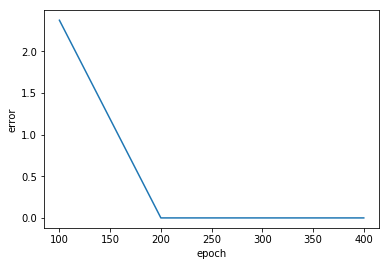

In [9]:
params_linear_r10=train(rand_data, rand_data, 10, 400, learning_rate=4, batch_size=100)

Internal activation: relu
loss func: L2
Learning rate: 1
batch size: 100
internal #epochs: 1000
It takes 5.79716396332 seconds
The error: 181.626


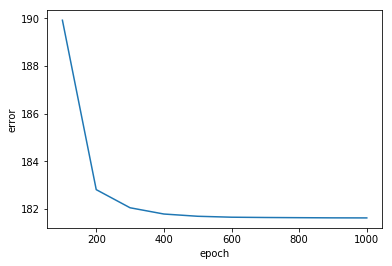

In [10]:
params_sigmoid_r10=train(rand_data, rand_data, 10, 1000, internal_act='relu', learning_rate=1, batch_size=100)

## Run on real data

We compute the embedding on a graph with 81306 vertices and 1768149 vertices. To embed the graph into 10 dimensions, we start with the most densest columns and increase the number of columns to embed. When we increase the number of columns to embed, we use the parameters trained from the previous run (on the dataset with a smaller number of columns).

In [11]:
elg = nx.read_edgelist("/home/ubuntu/datasets/twitter_combined.txt", create_using=nx.DiGraph())
spm = nx.to_scipy_sparse_matrix(elg, dtype='f')

In [12]:
def get_densest_idx(spm, num):
    colsum = np.ravel(spm.sum(axis=0))
    max_cols = np.sort(np.ravel(colsum), axis=None)[len(colsum) - num]
    return max_cols, colsum >= max_cols

def get_densest(spm, num):
    max_cols, idx = get_densest_idx(spm, num)
    sp_data = spm[:,idx]
    return sp_data

def get_densest2(spm, num1, num2):
    colsum = np.ravel(spm.sum(axis=1))
    sorted_colsum = np.sort(np.ravel(colsum), axis=None)
    max_cols1 = sorted_colsum[len(colsum) - num1]
    max_cols2 = sorted_colsum[len(colsum) - (num2 + num1)]
    sp_data1 = spm[:,colsum >= max_cols1]
    sp_data2 = spm[:,np.logical_and(colsum >= max_cols2, colsum < max_cols1)]
    return sp_data1, sp_data2

There are 81306 edges.


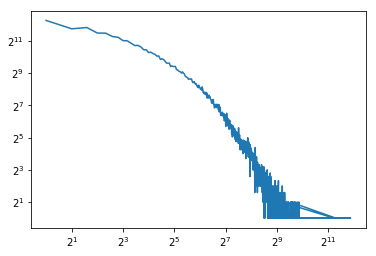

In [13]:
def deg_loglog(g):
    from collections import Counter
    nx_deg = nx.degree(g)
    deg = []
    for n, d in nx_deg:
        deg.append(d)
    cnt = Counter(deg)
    print('There are ' + str(sum(cnt.values())) + ' edges.')
    plt.loglog(cnt.keys(), cnt.values(), basex=2, basey=2)
    plt.show()
    
deg_loglog(elg)

### Curriculum learning

With curriculum learning, we can take advantage of the computation results from the denser columns.
To some extent, curriculum learning provides a new way of initializing the parameters of a neural network. We take the parameters from the neural network trained for the denser columns of a graph to initialize the neural network for the dataset with more columns.

The functions below expand and shrink the weight matrices for the smaller or the larger neural networks.

In [14]:
def init_params_svd(data, num_hidden):
    num_inputs = data.shape[1]
    U, s, Vh = sp.sparse.linalg.svds(data, k=num_hidden)
    
    new_params = {}
    new_params.update({weight_names[0]: mx.ndarray.array(Vh)})
    new_params.update({bias_names[0]: mx.ndarray.random_uniform(shape=(num_hidden,))})
    new_params.update({weight_names[1]: mx.ndarray.array(Vh.T)})
    new_params.update({bias_names[1]: mx.ndarray.random_uniform(shape=(num_inputs,))})
    return new_params

# Extend the weight matrices in the encoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_encode(weight, bias, idx, num_inputs, num_outputs, init):
    if (isinstance(init, np.ndarray)):
        out_weight = init
    else:
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[0:weight.shape[0], idx] = weight.asnumpy()
    out_bias[0:bias.shape[0]] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# Extend the weight matrices in the decoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_decode(weight, bias, idx, num_inputs, num_outputs, init):
    if (isinstance(init, np.ndarray)):
        out_weight = init
    else:
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[idx, 0:weight.shape[1]] = weight.asnumpy()
    out_bias[idx] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# This function extends the parameter matrices in the small autoencoder
# to an autoencoder with the specified number of input nodes and hidden nodes.
def extend_params(params, new_data, new_hidden, new_outputs, rand_init=False):
    old_inputs = params.get(weight_names[0]).shape[1]
    old_hidden = params.get(bias_names[0]).shape[0]
    new_inputs = new_data.shape[1]
    max_cols, max_idx = get_densest_idx(new_data, old_inputs)
    
    
    num_inputs = new_data.shape[1]
    U, s, Vh = sp.sparse.linalg.svds(new_data, k=new_hidden)
    if (rand_init):
        init = True
    else:
        init = Vh
    weight, bias = extend_params_encode(params.get(weight_names[0]),
                                        params.get(bias_names[0]), max_idx,
                                        new_inputs, new_hidden, init)
    new_params = {}
    new_params.update({weight_names[0]: weight})
    new_params.update({bias_names[0]: bias})
    if (rand_init):
        init = True
    else:
        init = Vh.T
    weight, bias = extend_params_decode(params.get(weight_names[1]),
                                        params.get(bias_names[1]), max_idx,
                                        new_hidden, new_outputs, init)
    new_params.update({weight_names[1]: weight})
    new_params.update({bias_names[1]: bias})
    return new_params

### Compute the embedding on the densest 10 columns.

In [15]:
sp_data10 = get_densest(spm, 10)
data10 = mx.ndarray.sparse.csr_matrix(sp_data10)
print(mx.ndarray.sum(data10, axis=0))
print(data10.shape)


[ 1905.  1707.  3383.  2471.  2735.  2462.  2133.  2647.  3216.  2074.]
<NDArray 10 @cpu(0)>
(81306L, 10L)


In [16]:
np_data10 = data10.asnumpy()
U, s, Vh = sp.linalg.svd(np_data10, full_matrices=False)
low_dim_data = np.dot(np_data10, Vh.T)
print(low_dim_data.shape)
print(np.max(low_dim_data))
print(np.min(low_dim_data))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_data10))))

(81306, 10)
1.52169
-2.01995
svd error: 4.26812e-09


loss func: L2
Learning rate: 1.0
batch size: 2000
internal #epochs: 400
It takes 21.04211092 seconds
The error: 8.5589e-08


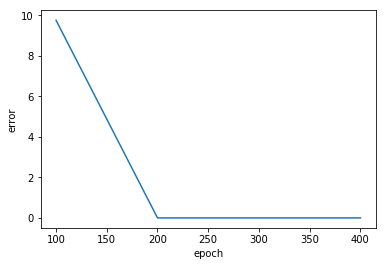

In [26]:
params_linear10=train(data10, data10, 10, 400, internal_act=None, learning_rate=1.0, batch_size=2000, use_sparse=True)

Internal activation: tanh
loss func: L2
Learning rate: 1.0
batch size: 2000
internal #epochs: 400
It takes 26.7076809406 seconds
The error: 6.78432


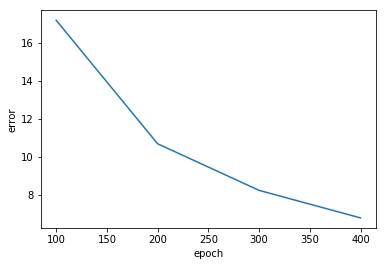

In [29]:
params_tanh10=train(data10, data10, 10, 400, internal_act='tanh', learning_rate=1.0, batch_size=2000, use_sparse=True)

Internal activation: relu
loss func: L2
Learning rate: 1
batch size: 2000
internal #epochs: 400
It takes 21.428508997 seconds
The error: 0.207369


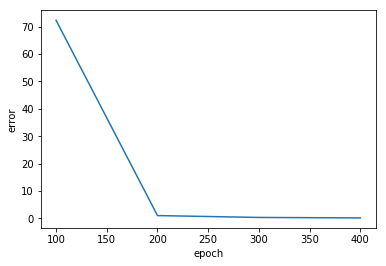

In [30]:
params_relu10=train(data10, data10, 10, 400, internal_act='relu', learning_rate=1, batch_size=2000, use_sparse=True)

### Train an autoencoder with curriculum learning

In [49]:
def train_cl(target_ndims, target_red_ndims, num_epoc, init_ndims=40,
             init_red_ndims=20, num_incs = 10, iact='relu', learning_rate=0.8,
             lr_inc=2, approx_loss=False, use_sparse=False):
    learning_rate = float(learning_rate)
    ndims = init_ndims
    red_ndims = init_red_ndims
    ndims_inc_exp = math.pow((float(target_ndims)/init_ndims), 1/float(num_incs))
    red_ndims_inc = (float(target_red_ndims) - init_red_ndims) / num_incs
    print("#dims increase by a factor of " + str(ndims_inc_exp))
    print("#red dims increase by " + str(red_ndims_inc))
    
    # This is the first run to train the small model.
    print("#dims: " + str(ndims))
    print("reduce #dims to " + str(red_ndims))
    sp_data = get_densest(spm, ndims)
    U, s, Vh = sp.sparse.linalg.svds(sp_data, k=red_ndims)
    res = np.dot(sp_data.dot(Vh.T), Vh)
    print("svd error: " + str(np.sum(np.square(res - sp_data))))
    data = mx.ndarray.sparse.csr_matrix(sp_data)
    y = mx.ndarray.dot(data, mx.ndarray.array(Vh.T))
    y = data
    model = AutoEncoderModel(data, y, num_dims=red_ndims, internal_act=iact,
                             learning_rate=learning_rate, batch_size=2000, use_sparse=use_sparse)
    params, _, errors = model.train(data, y, num_epoc=num_epoc, return_err=True, int_epoc=2)
    params_seq = [params]
    errors_seq = [errors]

    prev_Vh = None
    for i in range(num_incs):
        ndims = int(ndims * ndims_inc_exp)
        red_ndims = int(red_ndims + red_ndims_inc)
        print("#dims: " + str(ndims))
        print("reduce #dims to " + str(red_ndims))
        sp_data = get_densest(spm, ndims)
        U, s, Vh = sp.sparse.linalg.svds(sp_data, k=red_ndims)
        res = np.dot(sp_data.dot(Vh.T), Vh)
        print("svd error: " + str(np.sum(np.square(res - sp_data))))
        print("")

        data = mx.ndarray.sparse.csr_matrix(sp_data)
        Vh = None
        if (approx_loss and red_ndims * 1.5 < sp_data.shape[1]):
            _, _, Vh = sp.sparse.linalg.svds(sp_data, k=int(red_ndims * 1.5))
            y = mx.ndarray.dot(data, mx.ndarray.array(Vh.T))
            print("Approximate loss with " + str(y.shape[1]) + " dims")
        else:
            y = data
        
        # We use the previously trained model to initialize the current model.
        print("Train from previous results")
        # If we use sparse operations, we need to flip the weight matrix in the first layer
        # because the following operations (projection and parameter extension)
        # always assume the first dimension of the weight is for the hidden layer
        # and the second dimension is for the input layer.
        # TODO flipping a matrix can be expensive if the weight matrix is
        # very large. I'll fix it later.
        if (use_sparse):
            weight = params.get(weight_names[0])
            params.update({weight_names[0]: weight.T})
        if (prev_Vh is not None):
            weight = params.get(weight_names[1])
            weight = mx.ndarray.dot(mx.ndarray.array(prev_Vh.T), weight)
            params.update({weight_names[1]: weight})
            bias = params.get(bias_names[1])
            params.update({bias_names[1]: mx.ndarray.dot(mx.ndarray.array(prev_Vh.T), bias)})
        params_init = extend_params(params, sp_data, red_ndims, data.shape[1], rand_init=True)
        if (Vh is not None):
            weight = params_init.get(weight_names[1])
            params_init.update({weight_names[1]: mx.ndarray.dot(mx.ndarray.array(Vh), weight)})
            bias = params_init.get(bias_names[1])
            params_init.update({bias_names[1]: mx.ndarray.dot(mx.ndarray.array(Vh), bias)})
            prev_Vh = Vh
        if (use_sparse):
            weight = params_init.get(weight_names[0])
            params_init.update({weight_names[0]: weight.T})
        
        model = AutoEncoderModel(data, y, num_dims=red_ndims, internal_act=iact, learning_rate=learning_rate,
                                 batch_size=2000, proj=Vh, use_sparse=use_sparse)
        params, _, errors = model.train(data, y, num_epoc=num_epoc, return_err=True,
                                        params=params_init, int_epoc=2)
        params_seq.append(params)
        errors_seq.append(errors)
        # If the learning rate wasn't reduced during the training, we can increase
        # the learning rate for the next larger model.
        if (learning_rate == model.learning_rate):
            learning_rate = learning_rate * lr_inc

Below we run experiments with different configurations.
* Whether to approximate loss (`approx_loss`)
* How aggressively increase the number of input and hidden dimensions (`num_incs`). Larger `num_incs` increases less aggressively.
* How many iterations to train for each given (input and hidden) dimension.

Approximating loss not only reduces the training time almost by a factor of 3, but also significantly helps reduce the loss.

Increasing the number of input and hidden dimensions less aggressively can reduce the loss, but by a very small margin. Therefore, we should use a small `num_incs` to speedup.

Another finding is that we don't need many iterations to train for each dimension. Instead, we should use a larger learning rate to decrease the loss with a small number of iterations.

#dims increase by a factor of 1.14163099142
#red dims increase by 2.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 6.32303190231 seconds
The error: 14484.0


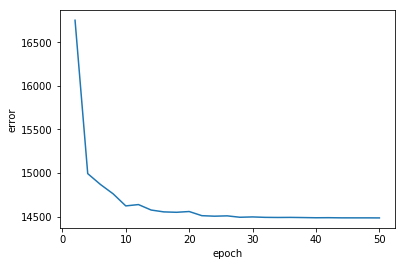

#dims: 45
reduce #dims to 22
svd error: 15658.7

Approximate loss with 33 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 6.54834103584 seconds
The error: 15675.9


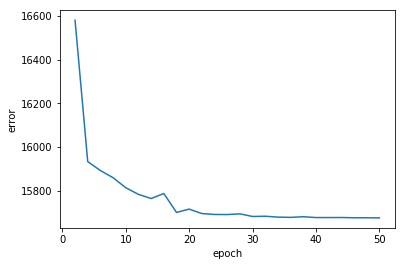

#dims: 51
reduce #dims to 24
svd error: 17505.4

Approximate loss with 36 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 6.54856681824 seconds
The error: 17586.0


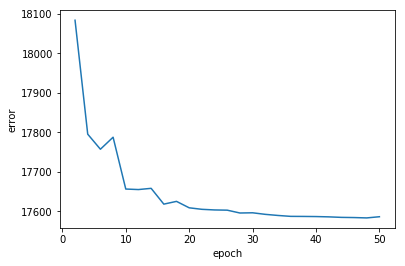

#dims: 58
reduce #dims to 26
svd error: 19876.2

Approximate loss with 39 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
reinit optimizer. New learning rate: 0.125
reinit optimizer. New learning rate: 0.0625
It takes 7.74801516533 seconds
The error: 19966.7


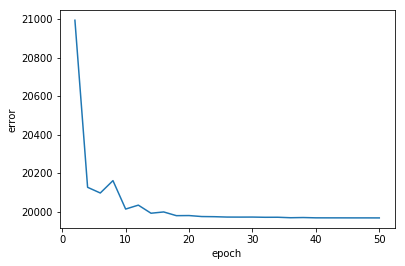

#dims: 66
reduce #dims to 28
svd error: 23086.2

Approximate loss with 42 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 9.14333987236 seconds
The error: 23176.0


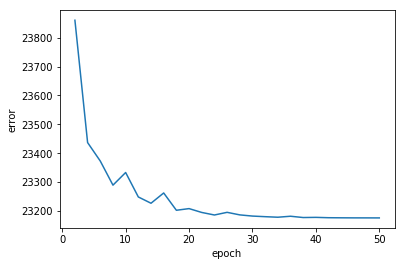

#dims: 75
reduce #dims to 30
svd error: 25858.0

Approximate loss with 45 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 9.10877799988 seconds
The error: 25892.0


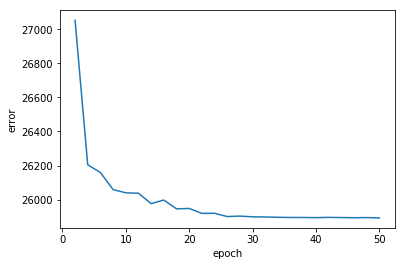

#dims: 85
reduce #dims to 32
svd error: 29855.3

Approximate loss with 48 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 8.76951098442 seconds
The error: 29877.8


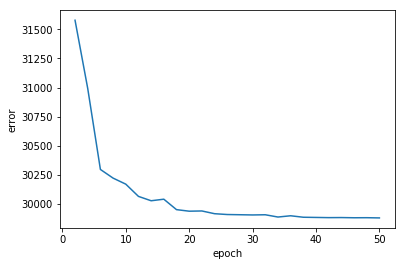

#dims: 97
reduce #dims to 34
svd error: 33382.0

Approximate loss with 51 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 10.1567428112 seconds
The error: 33425.9


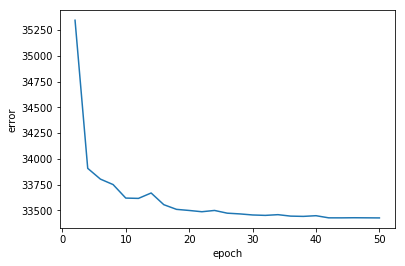

#dims: 110
reduce #dims to 36
svd error: 37653.6

Approximate loss with 54 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 11.7610108852 seconds
The error: 37882.3


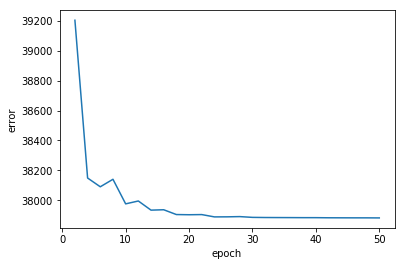

#dims: 125
reduce #dims to 38
svd error: 42048.5

Approximate loss with 57 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 13.060074091 seconds
The error: 42227.4


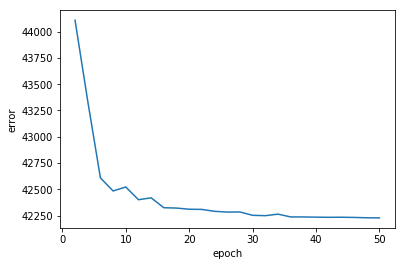

#dims: 142
reduce #dims to 40
svd error: 47232.8

Approximate loss with 60 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 13.8674588203 seconds
The error: 47365.2


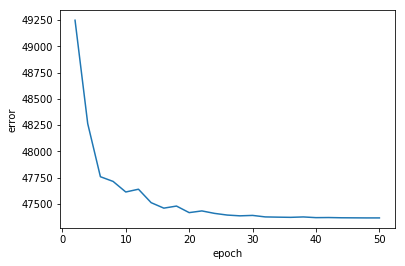

#dims: 162
reduce #dims to 42
svd error: 52506.3

Approximate loss with 63 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 15.6196711063 seconds
The error: 52624.4


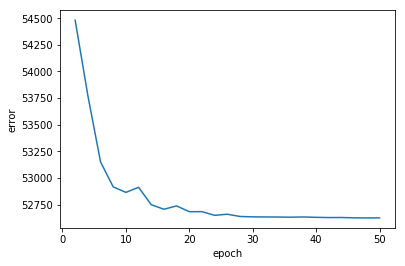

#dims: 184
reduce #dims to 44
svd error: 57972.8

Approximate loss with 66 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 17.1454620361 seconds
The error: 58046.4


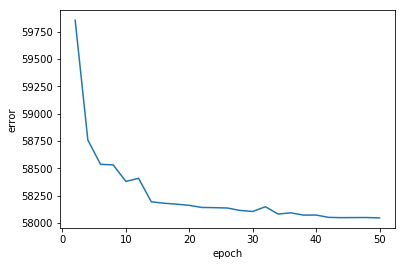

#dims: 210
reduce #dims to 46
svd error: 64194.6

Approximate loss with 69 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 18.5573830605 seconds
The error: 64309.6


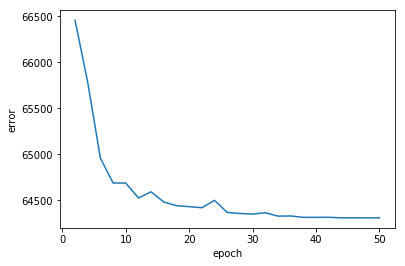

#dims: 239
reduce #dims to 48
svd error: 71096.4

Approximate loss with 72 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 19.0471827984 seconds
The error: 71176.8


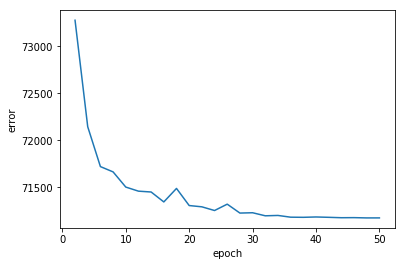

#dims: 272
reduce #dims to 50
svd error: 78701.9

Approximate loss with 75 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
reinit optimizer. New learning rate: 0.125
It takes 22.3025648594 seconds
The error: 78851.4


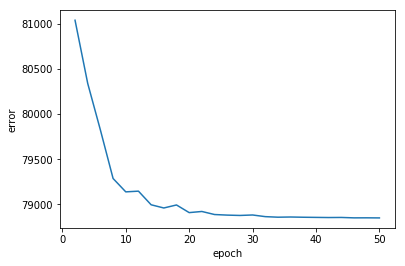

#dims: 310
reduce #dims to 52
svd error: 85999.0

Approximate loss with 78 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 23.7814309597 seconds
The error: 86141.5


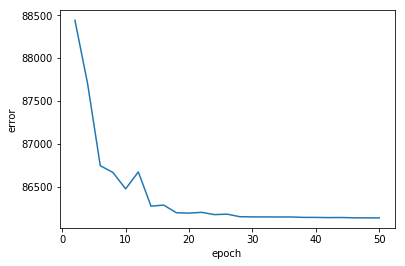

#dims: 353
reduce #dims to 54
svd error: 94736.9

Approximate loss with 81 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
reinit optimizer. New learning rate: 0.125
It takes 26.9043679237 seconds
The error: 94902.1


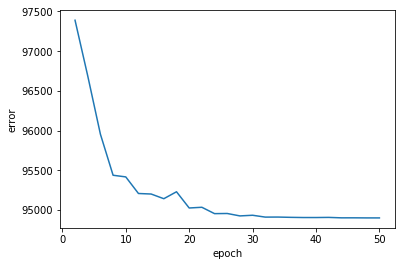

#dims: 402
reduce #dims to 56
svd error: 104708.0

Approximate loss with 84 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 30.2804470062 seconds
The error: 104866.0


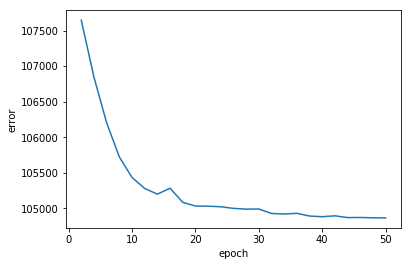

#dims: 458
reduce #dims to 58
svd error: 114799.0

Approximate loss with 87 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 33.5832641125 seconds
The error: 114990.0


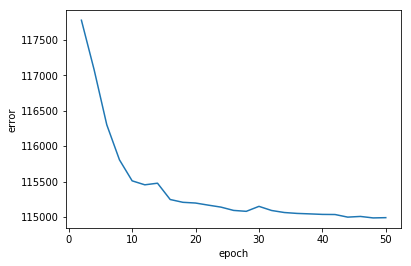

#dims: 522
reduce #dims to 60
svd error: 125318.0

Approximate loss with 90 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 36.8513920307 seconds
The error: 125588.0


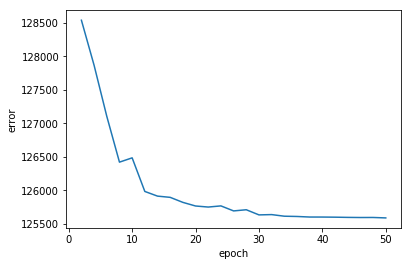

#dims: 595
reduce #dims to 62
svd error: 138381.0

Approximate loss with 93 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 40.2889270782 seconds
The error: 138695.0


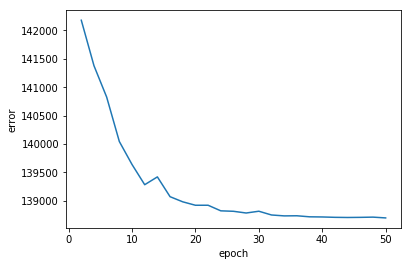

#dims: 679
reduce #dims to 64
svd error: 151308.0

Approximate loss with 96 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 39.0554249287 seconds
The error: 151610.0


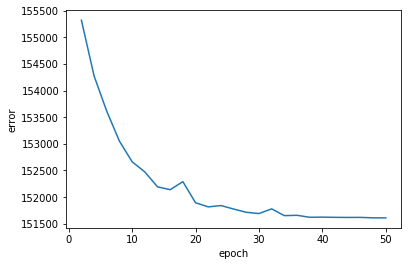

#dims: 775
reduce #dims to 66
svd error: 165031.0

Approximate loss with 99 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 45.3835749626 seconds
The error: 165297.0


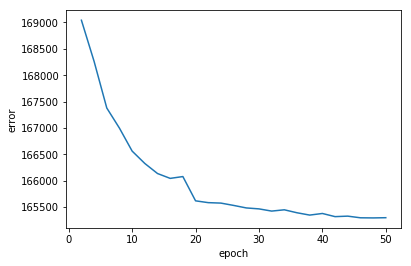

#dims: 884
reduce #dims to 68
svd error: 181194.0

Approximate loss with 102 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 51.9842259884 seconds
The error: 181673.0


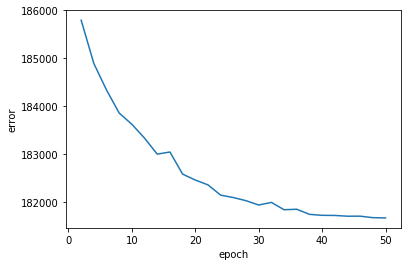

#dims: 1009
reduce #dims to 70
svd error: 196638.0

Approximate loss with 105 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 63.413326025 seconds
The error: 197083.0


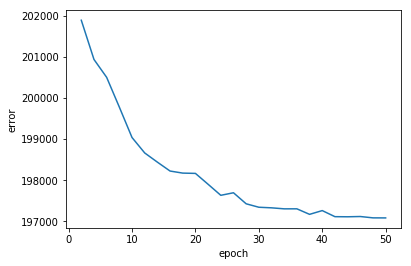

#dims: 1151
reduce #dims to 72
svd error: 212816.0

Approximate loss with 108 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 66.3553659916 seconds
The error: 213403.0


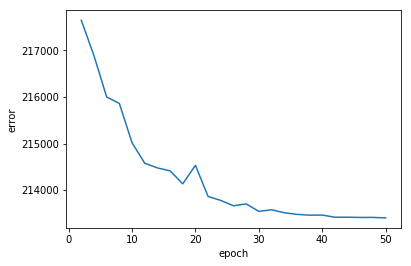

#dims: 1314
reduce #dims to 74
svd error: 229402.0

Approximate loss with 111 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 77.7928099632 seconds
The error: 230075.0


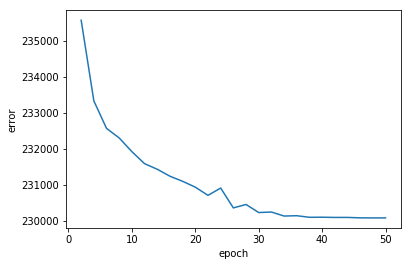

#dims: 1500
reduce #dims to 76
svd error: 247765.0

Approximate loss with 114 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 88.4486699104 seconds
The error: 248775.0


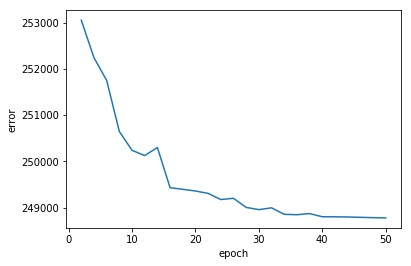

#dims: 1712
reduce #dims to 78
svd error: 267604.0

Approximate loss with 117 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 97.1718571186 seconds
The error: 268663.0


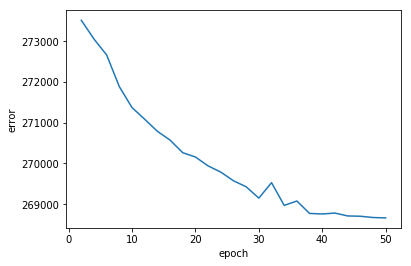

#dims: 1954
reduce #dims to 80
svd error: 288534.0

Approximate loss with 120 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 109.440481901 seconds
The error: 290242.0


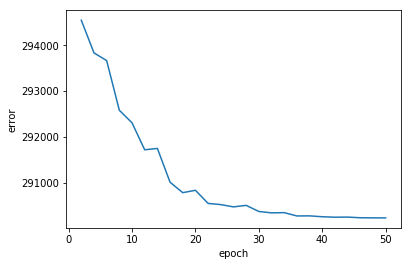

#dims: 2230
reduce #dims to 82
svd error: 310099.0

Approximate loss with 123 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 123.025661945 seconds
The error: 312029.0


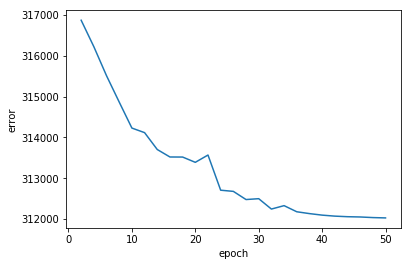

#dims: 2545
reduce #dims to 84
svd error: 333508.0

Approximate loss with 126 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 140.218358994 seconds
The error: 335520.0


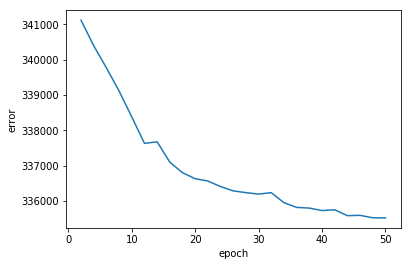

#dims: 2905
reduce #dims to 86
svd error: 358536.0

Approximate loss with 129 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 165.188046932 seconds
The error: 361441.0


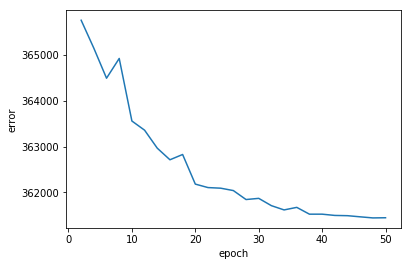

#dims: 3316
reduce #dims to 88
svd error: 384816.0

Approximate loss with 132 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 182.928434849 seconds
The error: 387933.0


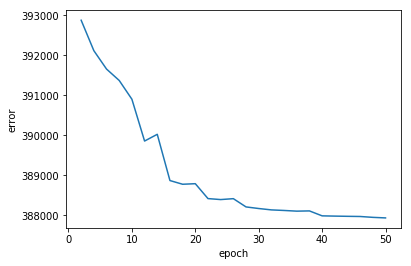

#dims: 3785
reduce #dims to 90
svd error: 414046.0

Approximate loss with 135 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 214.025542021 seconds
The error: 417006.0


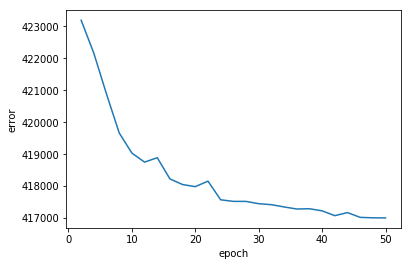

#dims: 4321
reduce #dims to 92
svd error: 443092.0

Approximate loss with 138 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 238.506517172 seconds
The error: 446317.0


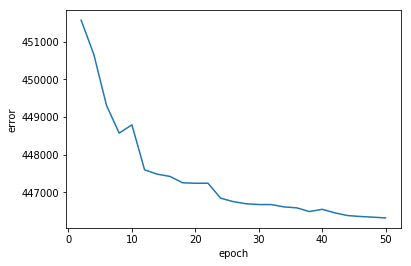

#dims: 4932
reduce #dims to 94
svd error: 473047.0

Approximate loss with 141 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 266.326189041 seconds
The error: 476632.0


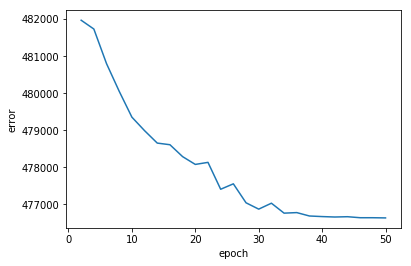

#dims: 5630
reduce #dims to 96
svd error: 507399.0

Approximate loss with 144 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 275.730861902 seconds
The error: 511802.0


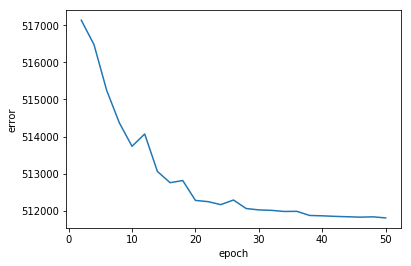

#dims: 6427
reduce #dims to 98
svd error: 549188.0

Approximate loss with 147 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 332.289516926 seconds
The error: 554660.0


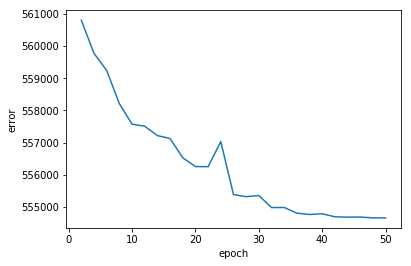

#dims: 7337
reduce #dims to 100
svd error: 584708.0

Approximate loss with 150 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 381.244015932 seconds
The error: 591385.0


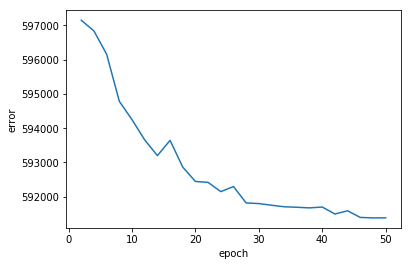

In [51]:
train_cl(8000, 100, 50, num_incs=40, learning_rate=16, approx_loss=True)

#dims increase by a factor of 1.30332132056
#red dims increase by 4.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 7.05943703651 seconds
The error: 14554.4


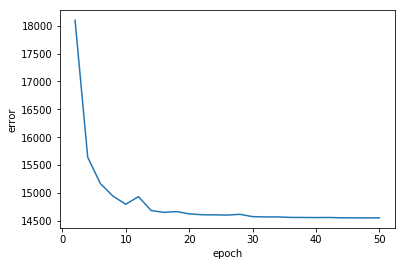

#dims: 52
reduce #dims to 24
svd error: 17909.6

Approximate loss with 36 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 7.50312709808 seconds
The error: 17987.4


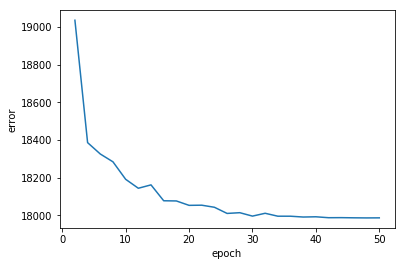

#dims: 67
reduce #dims to 28
svd error: 23735.0

Approximate loss with 42 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 9.14553117752 seconds
The error: 23793.4


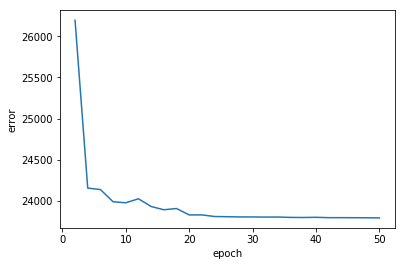

#dims: 87
reduce #dims to 32
svd error: 31096.9

Approximate loss with 48 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 9.97365283966 seconds
The error: 31163.8


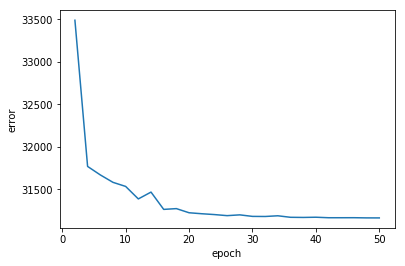

#dims: 113
reduce #dims to 36
svd error: 38571.8

Approximate loss with 54 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 13.5488529205 seconds
The error: 38678.4


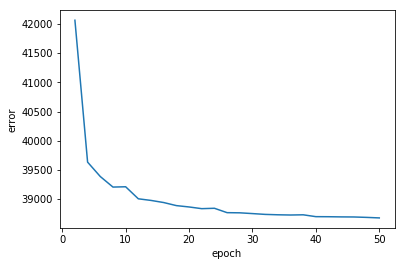

#dims: 147
reduce #dims to 40
svd error: 48809.2

Approximate loss with 60 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 15.5556941032 seconds
The error: 49012.0


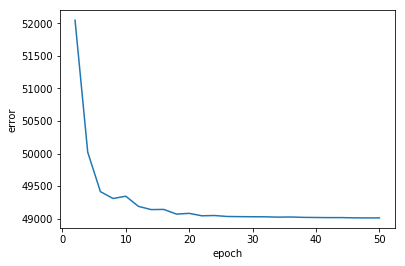

#dims: 191
reduce #dims to 44
svd error: 60142.5

Approximate loss with 66 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 18.305177927 seconds
The error: 60390.4


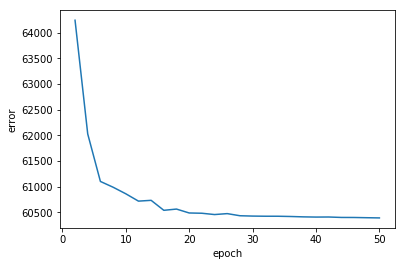

#dims: 248
reduce #dims to 48
svd error: 73567.6

Approximate loss with 72 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 20.8530919552 seconds
The error: 73824.8


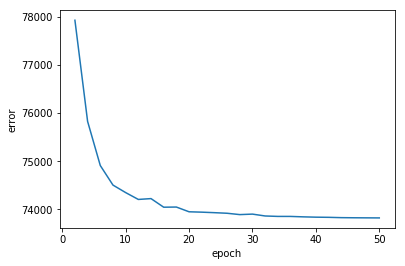

#dims: 323
reduce #dims to 52
svd error: 89254.4

Approximate loss with 78 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 27.35718894 seconds
The error: 89372.0


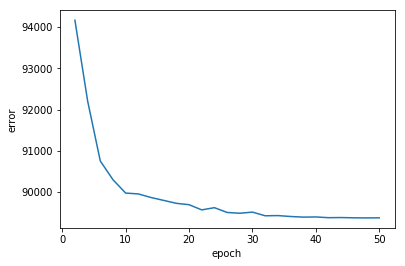

#dims: 420
reduce #dims to 56
svd error: 108543.0

Approximate loss with 84 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 30.1685080528 seconds
The error: 108750.0


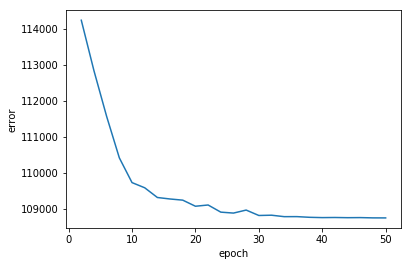

#dims: 547
reduce #dims to 60
svd error: 130275.0

Approximate loss with 90 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 35.6521859169 seconds
The error: 130737.0


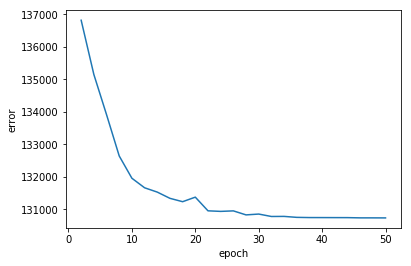

#dims: 712
reduce #dims to 64
svd error: 156176.0

Approximate loss with 96 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 41.4994430542 seconds
The error: 156709.0


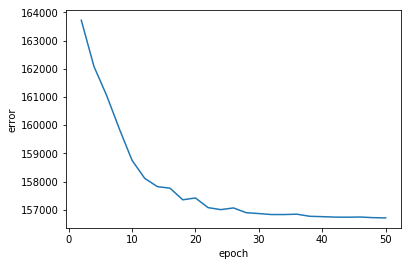

#dims: 927
reduce #dims to 68
svd error: 186797.0

Approximate loss with 102 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 49.2358398438 seconds
The error: 187286.0


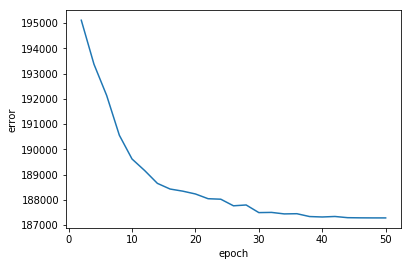

#dims: 1208
reduce #dims to 72
svd error: 221097.0

Approximate loss with 108 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 63.0366020203 seconds
The error: 222274.0


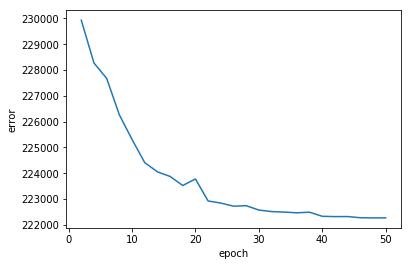

#dims: 1574
reduce #dims to 76
svd error: 256351.0

Approximate loss with 114 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 82.0615620613 seconds
The error: 257486.0


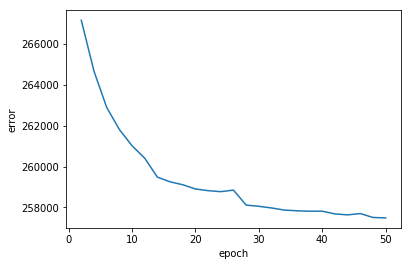

#dims: 2051
reduce #dims to 80
svd error: 296031.0

Approximate loss with 120 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 102.672207832 seconds
The error: 298160.0


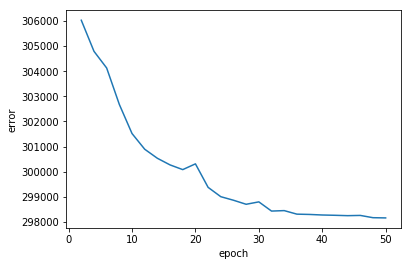

#dims: 2673
reduce #dims to 84
svd error: 343786.0

Approximate loss with 126 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 134.593120098 seconds
The error: 346419.0


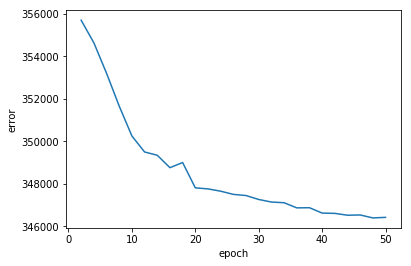

#dims: 3483
reduce #dims to 88
svd error: 397952.0

Approximate loss with 132 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 172.665213108 seconds
The error: 401685.0


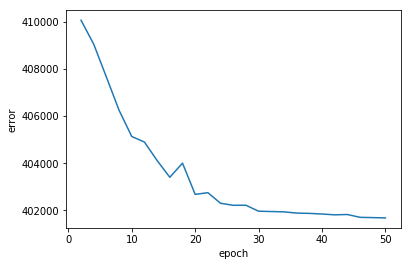

#dims: 4539
reduce #dims to 92
svd error: 453643.0

Approximate loss with 138 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 215.846121073 seconds
The error: 458076.0


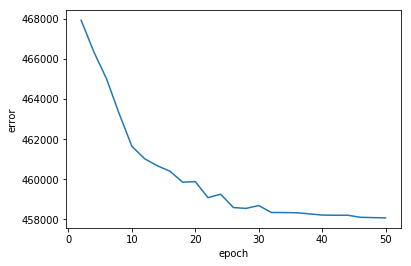

#dims: 5915
reduce #dims to 96
svd error: 520477.0

Approximate loss with 144 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 264.453070879 seconds
The error: 525050.0


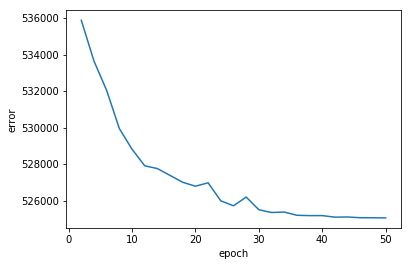

#dims: 7709
reduce #dims to 100
svd error: 593466.0

Approximate loss with 150 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 352.085129023 seconds
The error: 599485.0


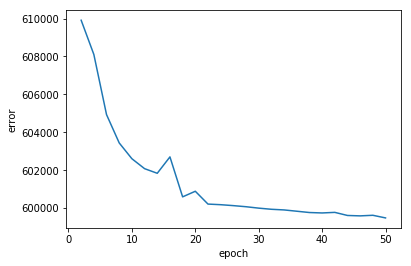

In [13]:
train_cl(8000, 100, 50, num_incs=20, learning_rate=16, approx_loss=True)

#dims increase by a factor of 1.69864646463
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 7.15066599846 seconds
The error: 14525.0


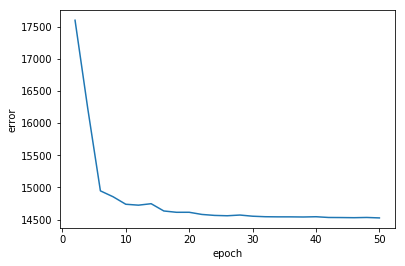

#dims: 67
reduce #dims to 28
svd error: 23735.0

Approximate loss with 42 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 9.15347385406 seconds
The error: 23794.0


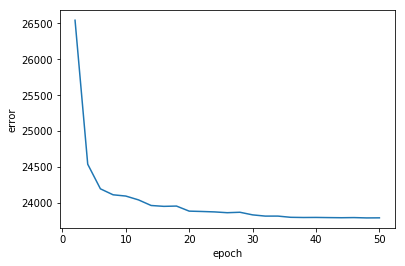

#dims: 113
reduce #dims to 36
svd error: 38571.8

Approximate loss with 54 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 14.1667749882 seconds
The error: 38742.6


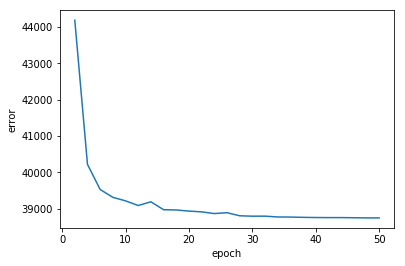

#dims: 191
reduce #dims to 44
svd error: 60142.5

Approximate loss with 66 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 18.1601071358 seconds
The error: 60376.8


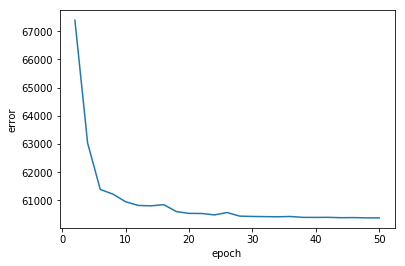

#dims: 324
reduce #dims to 52
svd error: 89254.4

Approximate loss with 78 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 28.5056900978 seconds
The error: 89481.8


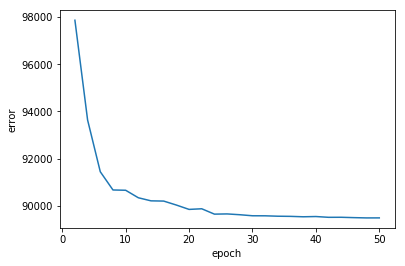

#dims: 550
reduce #dims to 60
svd error: 130925.0

Approximate loss with 90 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 36.6426849365 seconds
The error: 131333.0


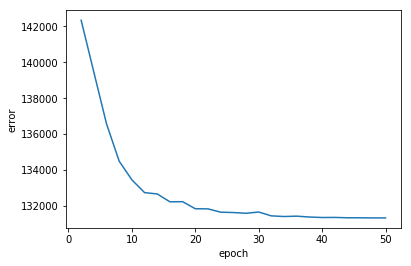

#dims: 934
reduce #dims to 68
svd error: 187582.0

Approximate loss with 102 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 49.8087890148 seconds
The error: 188490.0


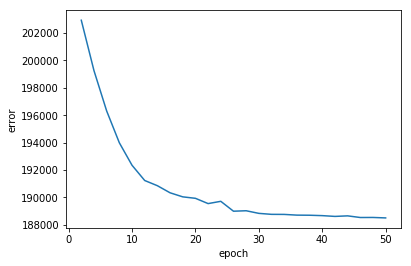

#dims: 1586
reduce #dims to 76
svd error: 256351.0

Approximate loss with 114 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 79.7426168919 seconds
The error: 258115.0


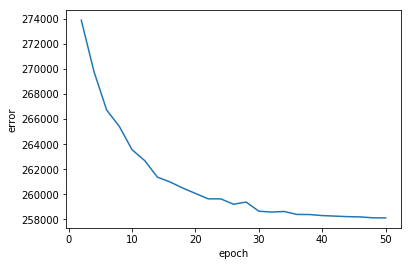

#dims: 2694
reduce #dims to 84
svd error: 343786.0

Approximate loss with 126 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 135.265032053 seconds
The error: 347212.0


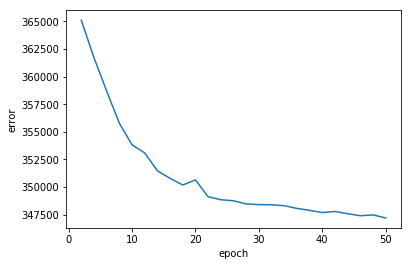

#dims: 4576
reduce #dims to 92
svd error: 458074.0

Approximate loss with 138 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 220.892548084 seconds
The error: 463845.0


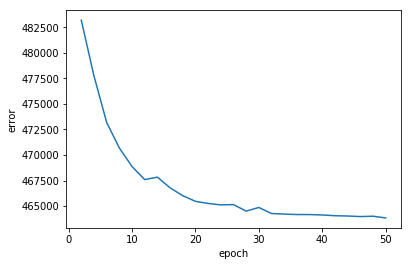

#dims: 7773
reduce #dims to 100
svd error: 602304.0

Approximate loss with 150 dims
Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 359.938053846 seconds
The error: 609898.0


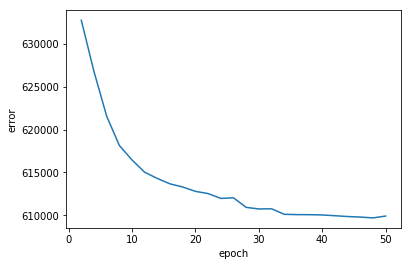

In [15]:
train_cl(8000, 100, 50, num_incs=10, learning_rate=16, approx_loss=True)

#dims increase by a factor of 1.69864646463
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 3.50380802155 seconds
The error: 14643.0


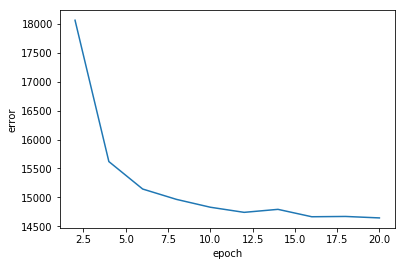

#dims: 67
reduce #dims to 28
svd error: 23735.0

Approximate loss with 42 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 4.60126495361 seconds
The error: 23919.6


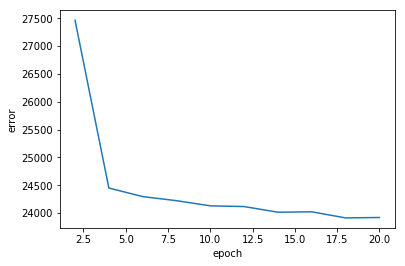

#dims: 113
reduce #dims to 36
svd error: 38571.8

Approximate loss with 54 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 6.15877103806 seconds
The error: 38852.7


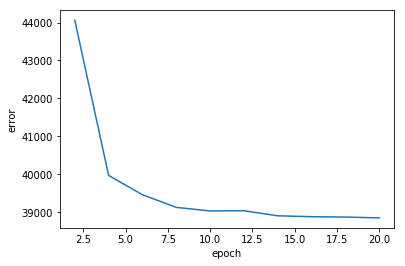

#dims: 191
reduce #dims to 44
svd error: 60142.5

Approximate loss with 66 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 8.41146183014 seconds
The error: 60471.5


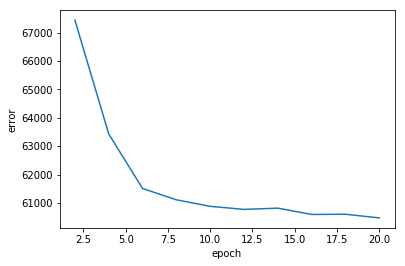

#dims: 324
reduce #dims to 52
svd error: 89254.5

Approximate loss with 78 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 11.4575200081 seconds
The error: 89952.7


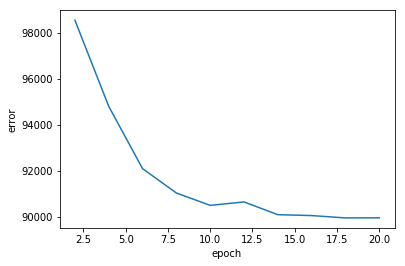

#dims: 550
reduce #dims to 60
svd error: 130925.0

Approximate loss with 90 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
It takes 16.3116159439 seconds
The error: 131997.0


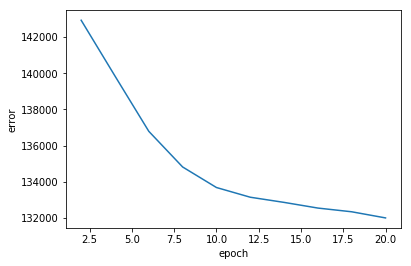

#dims: 934
reduce #dims to 68
svd error: 187582.0

Approximate loss with 102 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 22.5976657867 seconds
The error: 189231.0


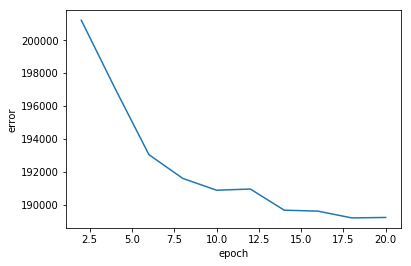

#dims: 1586
reduce #dims to 76
svd error: 256351.0

Approximate loss with 114 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 34.6049408913 seconds
The error: 258808.0


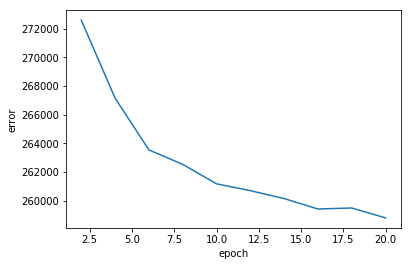

#dims: 2694
reduce #dims to 84
svd error: 343786.0

Approximate loss with 126 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0
It takes 53.3477540016 seconds
The error: 348919.0


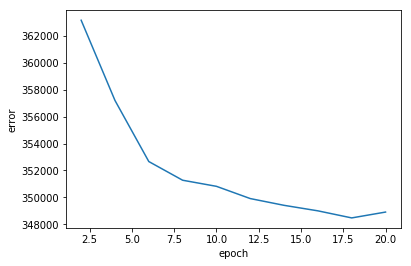

#dims: 4576
reduce #dims to 92
svd error: 458074.0

Approximate loss with 138 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 88.0460240841 seconds
The error: 463928.0


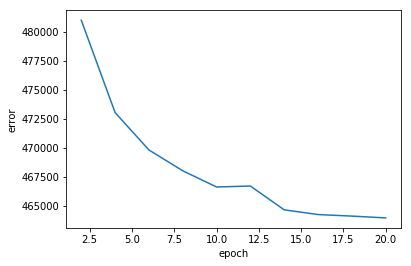

#dims: 7773
reduce #dims to 100
svd error: 602304.0

Approximate loss with 150 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0
It takes 139.921263933 seconds
The error: 610588.0


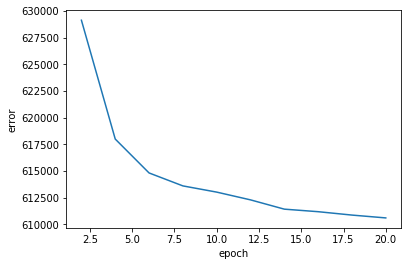

In [50]:
train_cl(8000, 100, 20, num_incs=10, learning_rate=16, approx_loss=True, use_sparse=True)

Below are experiments that don't approximate loss. They take much longer time to train and end up with a much larger loss.

#dims increase by a factor of 1.14163099142
#red dims increase by 2.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 7.25694394112 seconds
The error: 14494.8


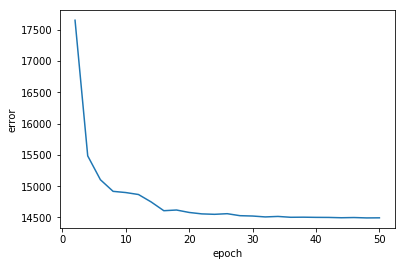

#dims: 45
reduce #dims to 22
svd error: 15658.7

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 7.911039114 seconds
The error: 15679.9


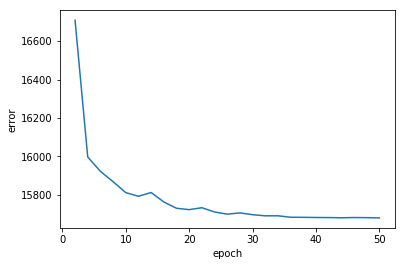

#dims: 51
reduce #dims to 24
svd error: 17505.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 8.34819793701 seconds
The error: 17607.9


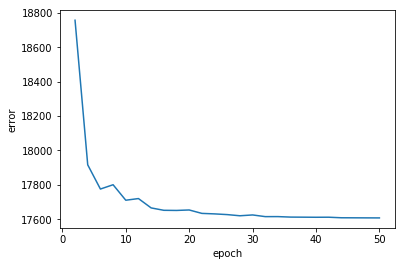

#dims: 58
reduce #dims to 26
svd error: 19876.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 10.1149969101 seconds
The error: 19941.0


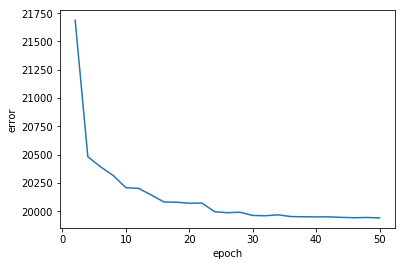

#dims: 66
reduce #dims to 28
svd error: 23086.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 10.2984600067 seconds
The error: 23147.2


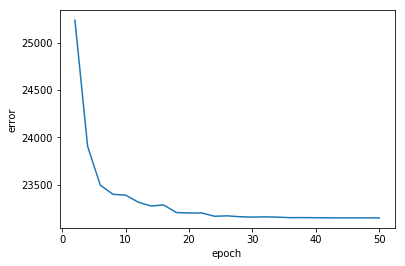

#dims: 75
reduce #dims to 30
svd error: 25858.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 11.8584370613 seconds
The error: 25905.2


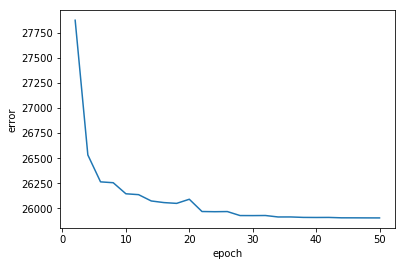

#dims: 85
reduce #dims to 32
svd error: 29855.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 13.8675870895 seconds
The error: 29938.0


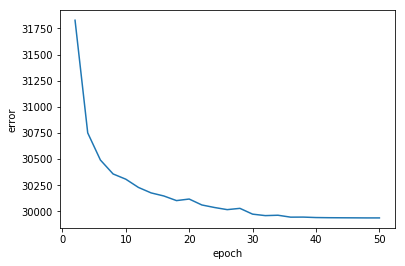

#dims: 97
reduce #dims to 34
svd error: 33382.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 15.9415650368 seconds
The error: 33554.7


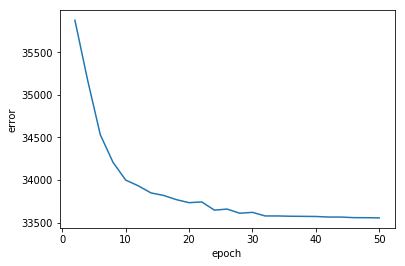

#dims: 110
reduce #dims to 36
svd error: 37653.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 18.4537651539 seconds
The error: 37797.3


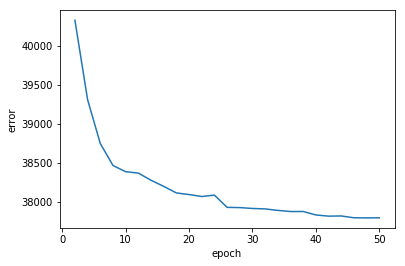

#dims: 125
reduce #dims to 38
svd error: 42048.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 19.8307318687 seconds
The error: 42208.7


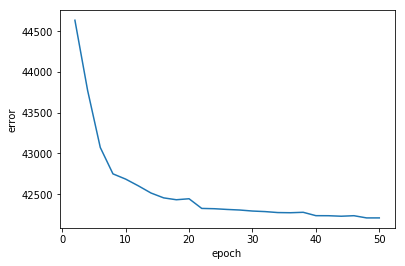

#dims: 142
reduce #dims to 40
svd error: 47232.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 21.6438949108 seconds
The error: 47390.8


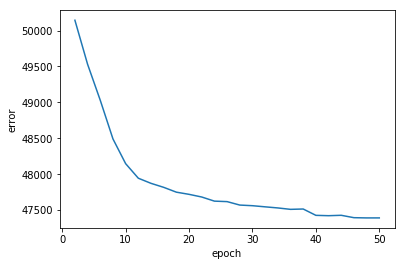

#dims: 162
reduce #dims to 42
svd error: 52506.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 25.3908779621 seconds
The error: 52689.6


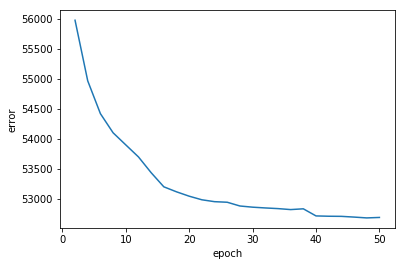

#dims: 184
reduce #dims to 44
svd error: 57972.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 28.5793819427 seconds
The error: 58174.1


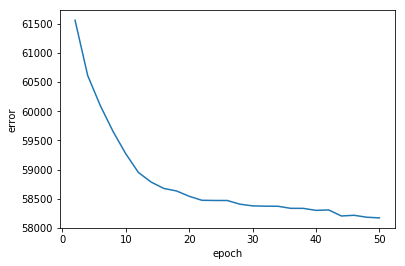

#dims: 210
reduce #dims to 46
svd error: 64194.7

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 34.1475310326 seconds
The error: 64487.5


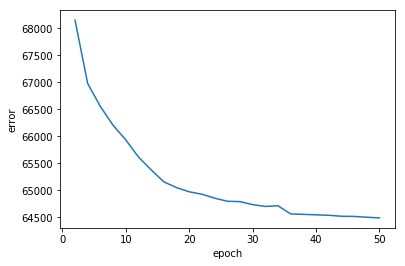

#dims: 239
reduce #dims to 48
svd error: 71096.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
It takes 36.9774229527 seconds
The error: 71516.8


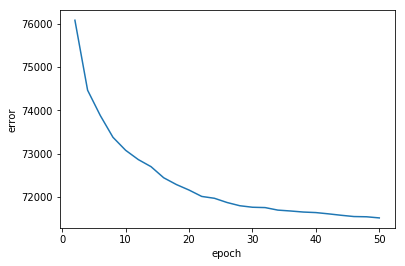

#dims: 272
reduce #dims to 50
svd error: 78701.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 38.314593792 seconds
The error: 78923.6


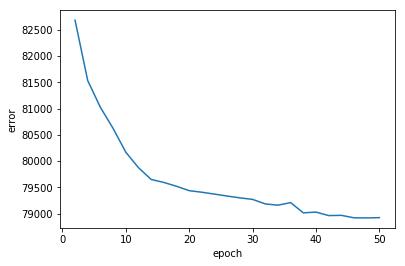

#dims: 310
reduce #dims to 52
svd error: 85999.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 43.5981988907 seconds
The error: 86360.3


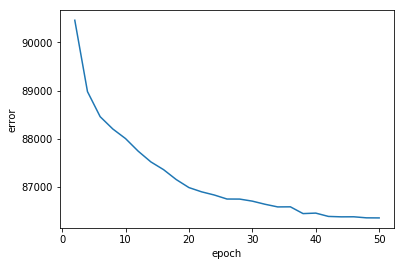

#dims: 353
reduce #dims to 54
svd error: 94736.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 48.6569440365 seconds
The error: 96049.8


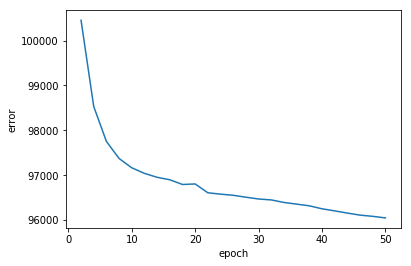

#dims: 402
reduce #dims to 56
svd error: 104708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
It takes 55.0708549023 seconds
The error: 105789.0


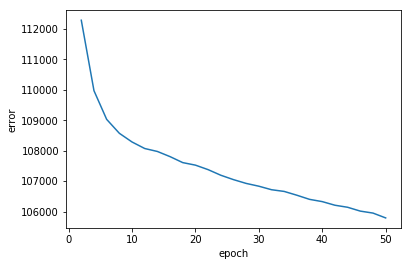

#dims: 458
reduce #dims to 58
svd error: 114799.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 61.3157410622 seconds
The error: 115938.0


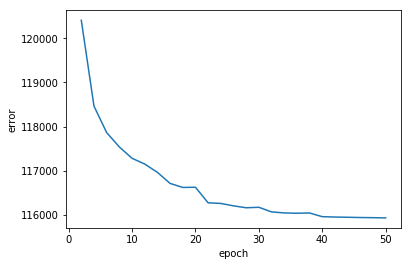

#dims: 522
reduce #dims to 60
svd error: 125318.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 71.0020358562 seconds
The error: 127866.0


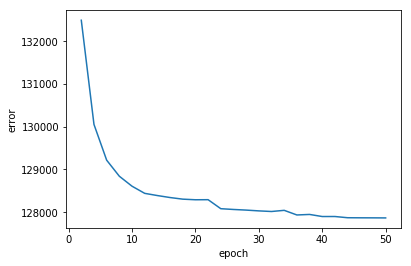

#dims: 595
reduce #dims to 62
svd error: 138381.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 80.1673030853 seconds
The error: 141897.0


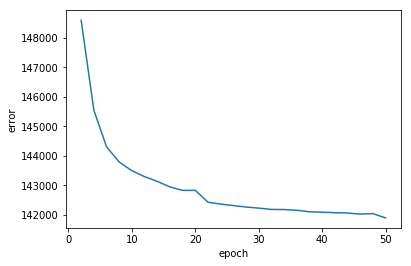

#dims: 679
reduce #dims to 64
svd error: 151308.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 86.0846300125 seconds
The error: 155666.0


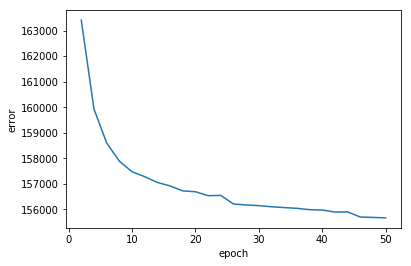

#dims: 775
reduce #dims to 66
svd error: 165031.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
It takes 100.688035011 seconds
The error: 170047.0


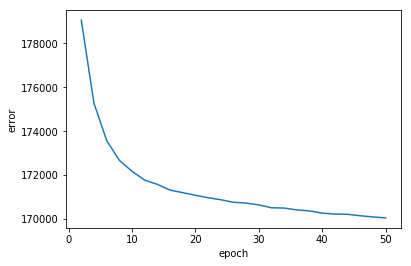

#dims: 884
reduce #dims to 68
svd error: 181194.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
It takes 113.445956945 seconds
The error: 185394.0


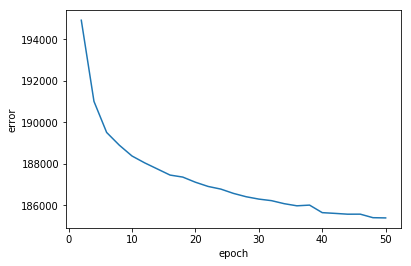

#dims: 1009
reduce #dims to 70
svd error: 196638.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
It takes 131.059556007 seconds
The error: 201623.0


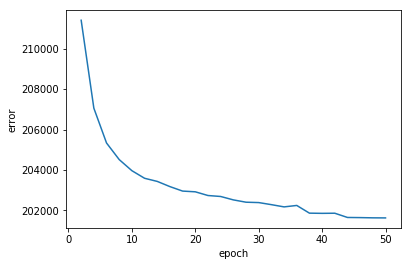

#dims: 1151
reduce #dims to 72
svd error: 212816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
It takes 146.00284481 seconds
The error: 219679.0


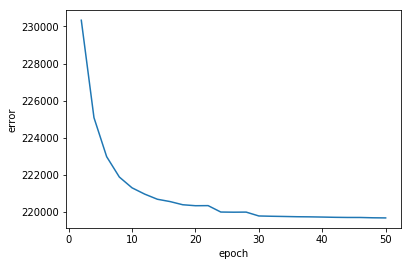

#dims: 1314
reduce #dims to 74
svd error: 229402.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 167.637413025 seconds
The error: 238148.0


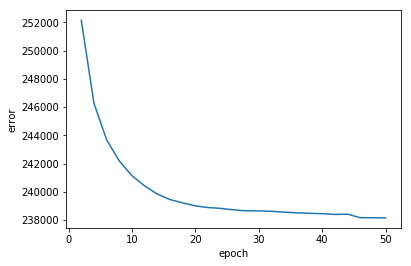

#dims: 1500
reduce #dims to 76
svd error: 247765.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 190.88003993 seconds
The error: 258060.0


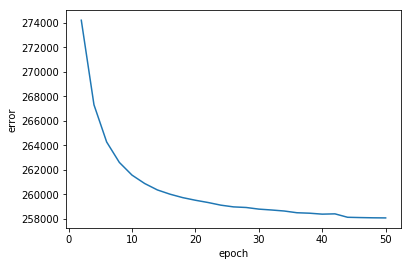

#dims: 1712
reduce #dims to 78
svd error: 267604.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
It takes 220.314502001 seconds
The error: 280322.0


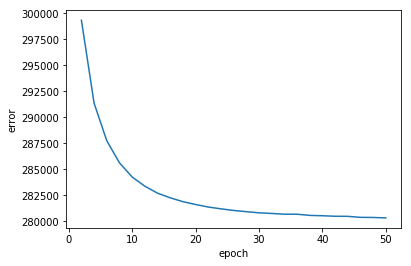

#dims: 1954
reduce #dims to 80
svd error: 288534.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 249.706595898 seconds
The error: 303056.0


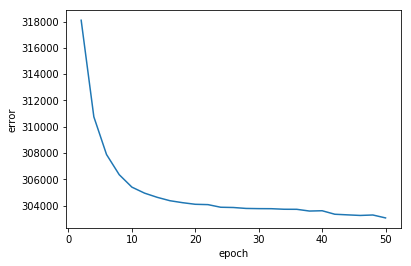

#dims: 2230
reduce #dims to 82
svd error: 310099.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 291.844092846 seconds
The error: 327540.0


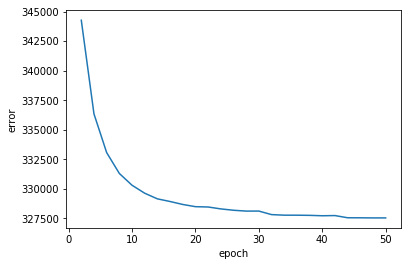

#dims: 2545
reduce #dims to 84
svd error: 333507.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
It takes 337.663317204 seconds
The error: 354710.0


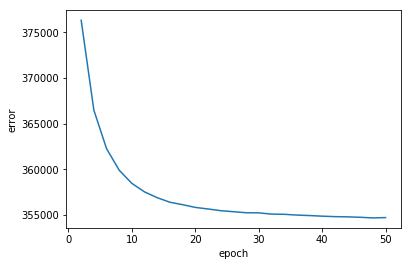

#dims: 2905
reduce #dims to 86
svd error: 358536.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
It takes 411.073120117 seconds
The error: 382734.0


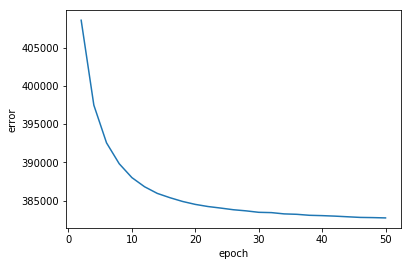

#dims: 3316
reduce #dims to 88
svd error: 384816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
It takes 435.537147045 seconds
The error: 411344.0


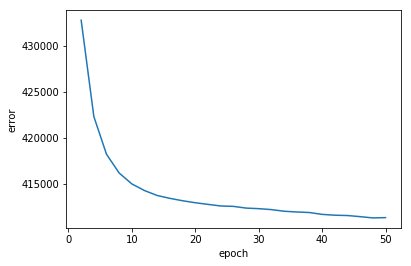

#dims: 3785
reduce #dims to 90
svd error: 414046.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
reinit optimizer. New learning rate: 256.0
It takes 532.863912821 seconds
The error: 443659.0


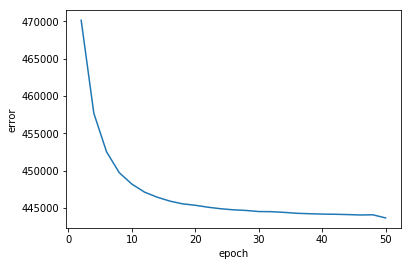

#dims: 4321
reduce #dims to 92
svd error: 443092.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
reinit optimizer. New learning rate: 256.0
It takes 570.255192041 seconds
The error: 477437.0


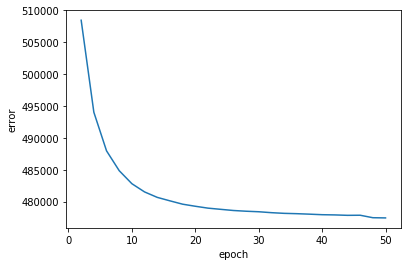

#dims: 4932
reduce #dims to 94
svd error: 473047.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
It takes 676.398443937 seconds
The error: 513371.0


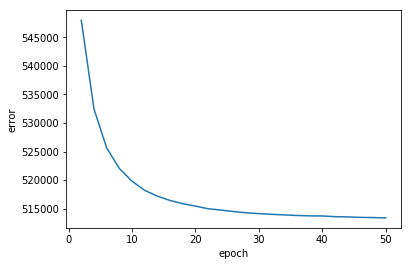

#dims: 5630
reduce #dims to 96
svd error: 507399.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 1024.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 1024.0
reinit optimizer. New learning rate: 512.0
It takes 752.790543079 seconds
The error: 552729.0


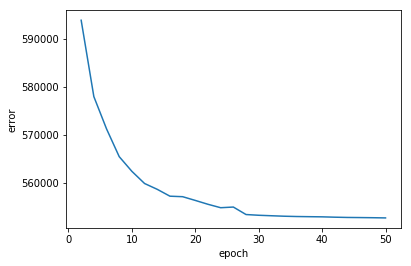

#dims: 6427
reduce #dims to 98
svd error: 549188.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 1024.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 1024.0
reinit optimizer. New learning rate: 512.0
It takes 955.161025047 seconds
The error: 601441.0


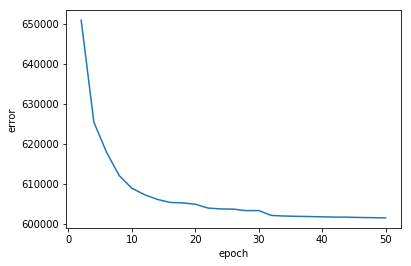

#dims: 7337
reduce #dims to 100
svd error: 584708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 1024.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 1024.0
reinit optimizer. New learning rate: 512.0
It takes 1031.35050011 seconds
The error: 643534.0


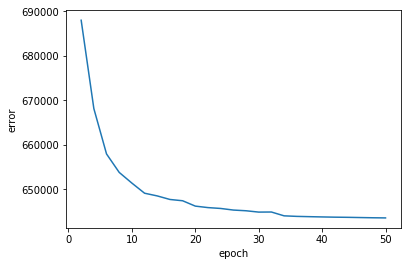

In [24]:
train_cl(8000, 100, 50, num_incs=40, learning_rate=16.0)

#dims increase by a factor of 1.69864646463
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
reinit optimizer. New learning rate: 0.125
reinit optimizer. New learning rate: 0.0625
It takes 14.6891829967 seconds
The error: 14525.4


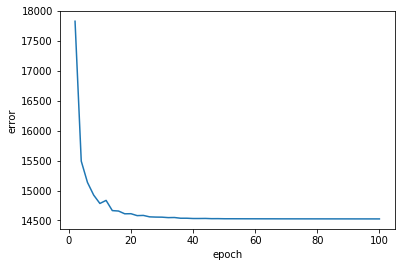

#dims: 67
reduce #dims to 28
svd error: 23735.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 22.599545002 seconds
The error: 23866.6


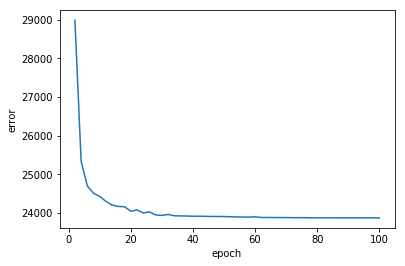

#dims: 113
reduce #dims to 36
svd error: 38571.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 35.4165098667 seconds
The error: 38698.2


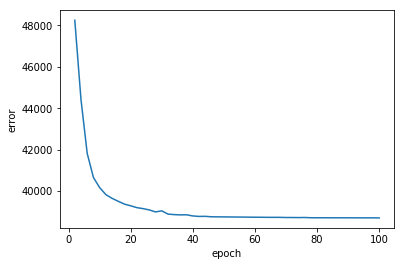

#dims: 191
reduce #dims to 44
svd error: 60142.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 57.7990870476 seconds
The error: 60297.5


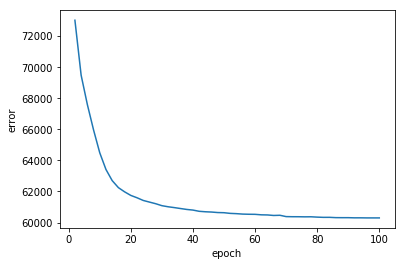

#dims: 324
reduce #dims to 52
svd error: 89254.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 92.1139090061 seconds
The error: 90452.6


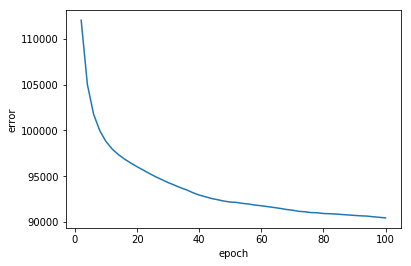

#dims: 550
reduce #dims to 60
svd error: 130925.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 152.147555828 seconds
The error: 136427.0


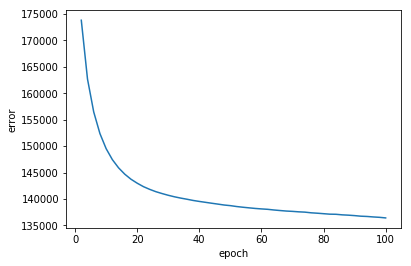

#dims: 934
reduce #dims to 68
svd error: 187582.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 240.725842953 seconds
The error: 201034.0


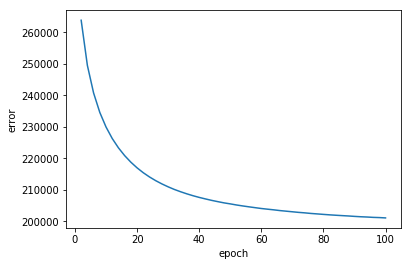

#dims: 1586
reduce #dims to 76
svd error: 256351.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 414.941539049 seconds
The error: 287537.0


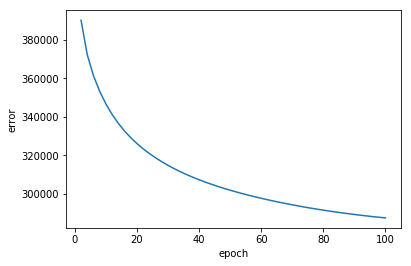

#dims: 2694
reduce #dims to 84
svd error: 343787.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 730.409393072 seconds
The error: 416397.0


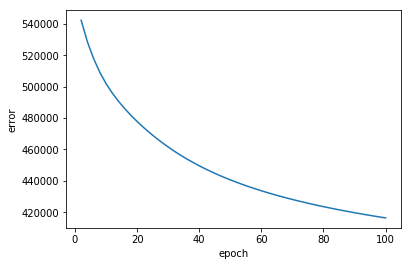

#dims: 4576
reduce #dims to 92
svd error: 458074.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 1320.96324396 seconds
The error: 613252.0


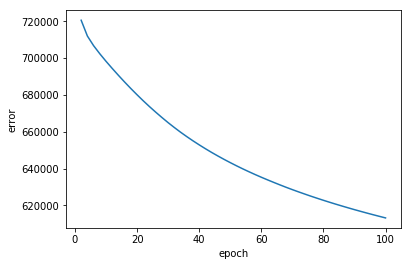

#dims: 7773
reduce #dims to 100
svd error: 602304.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 2399.38668704 seconds
The error: 861957.0


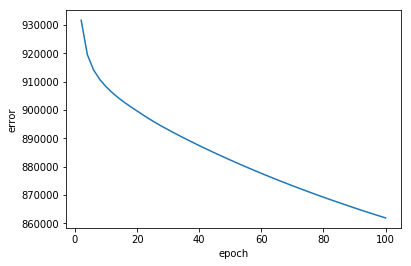

In [30]:
train_cl(8000, 100, 100, num_incs=10, learning_rate=16.0, lr_inc=1)

#dims increase by a factor of 1.14163099142
#red dims increase by 2.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 8.0
It takes 3.38410592079 seconds
The error: 14541.1


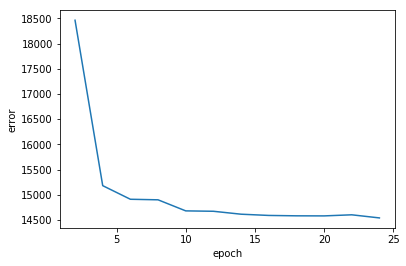

#dims: 45
reduce #dims to 22
svd error: 15658.7

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 3.93290090561 seconds
The error: 15739.9


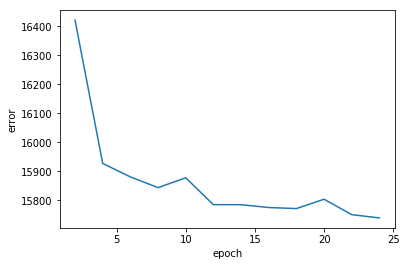

#dims: 51
reduce #dims to 24
svd error: 17505.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 3.92802906036 seconds
The error: 17610.2


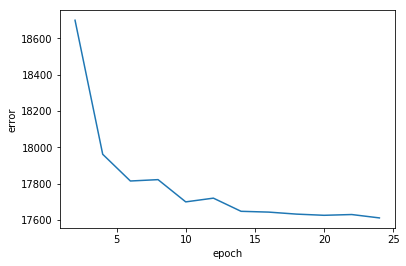

#dims: 58
reduce #dims to 26
svd error: 19876.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 4.75435495377 seconds
The error: 20008.0


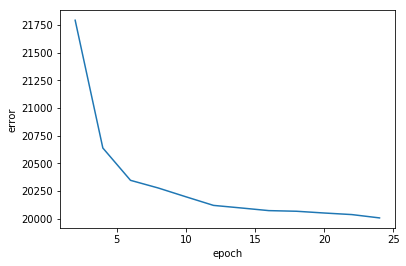

#dims: 66
reduce #dims to 28
svd error: 23086.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 5.20467591286 seconds
The error: 23168.0


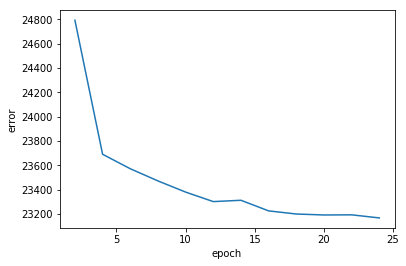

#dims: 75
reduce #dims to 30
svd error: 25858.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 5.79121184349 seconds
The error: 26056.0


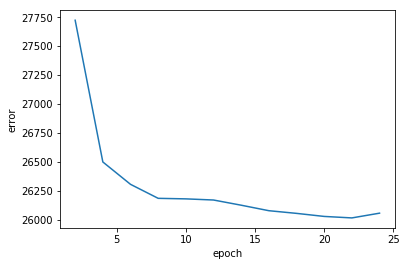

#dims: 85
reduce #dims to 32
svd error: 29855.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 6.12411999702 seconds
The error: 30048.5


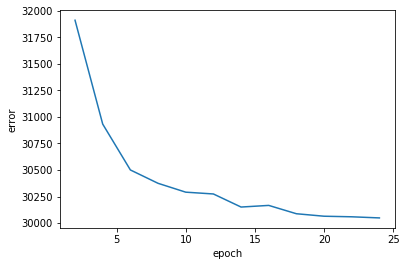

#dims: 97
reduce #dims to 34
svd error: 33382.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 6.77587413788 seconds
The error: 33597.5


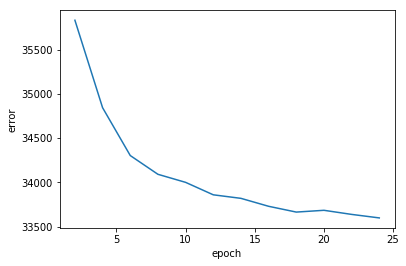

#dims: 110
reduce #dims to 36
svd error: 37653.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 10.2090530396 seconds
The error: 38001.3


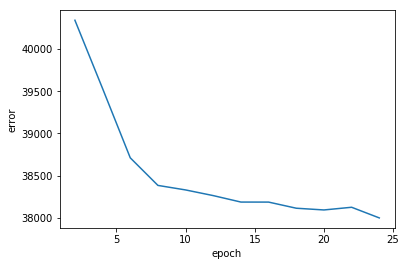

#dims: 125
reduce #dims to 38
svd error: 42048.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 9.90676307678 seconds
The error: 42548.5


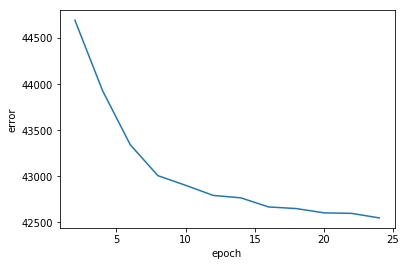

#dims: 142
reduce #dims to 40
svd error: 47232.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 10.2831470966 seconds
The error: 47691.3


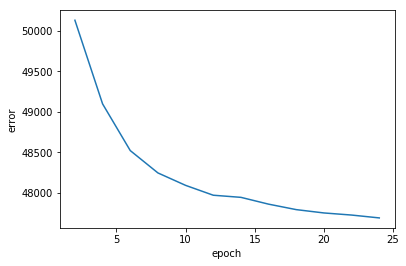

#dims: 162
reduce #dims to 42
svd error: 52506.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 12.5358920097 seconds
The error: 52932.8


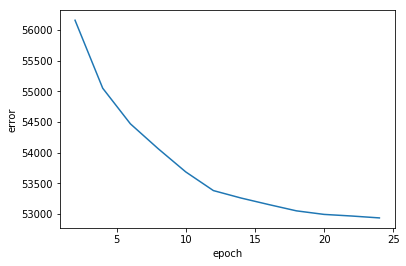

#dims: 184
reduce #dims to 44
svd error: 57972.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 12.9115929604 seconds
The error: 58545.5


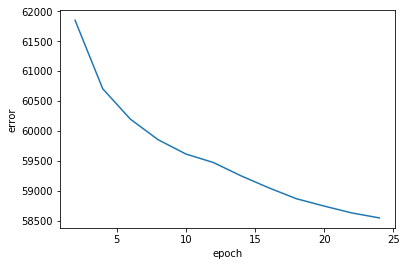

#dims: 210
reduce #dims to 46
svd error: 64194.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 16.5663249493 seconds
The error: 64937.0


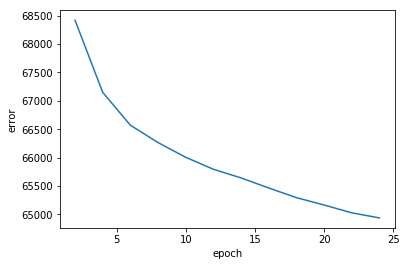

#dims: 239
reduce #dims to 48
svd error: 71096.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 16.5912599564 seconds
The error: 72309.9


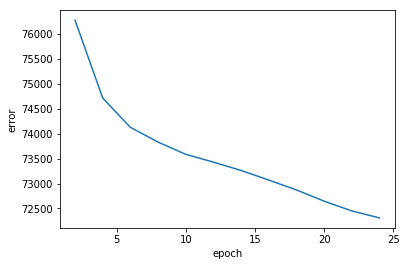

#dims: 272
reduce #dims to 50
svd error: 78701.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 18.9859731197 seconds
The error: 80222.1


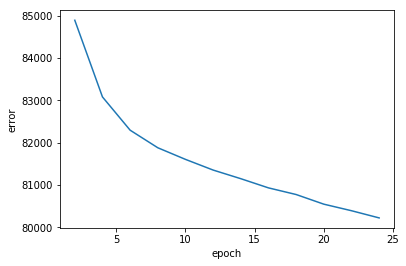

#dims: 310
reduce #dims to 52
svd error: 85999.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 21.4227380753 seconds
The error: 87807.1


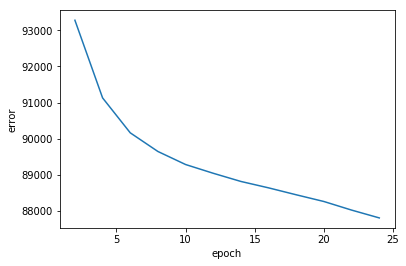

#dims: 353
reduce #dims to 54
svd error: 94736.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 25.4835059643 seconds
The error: 97337.7


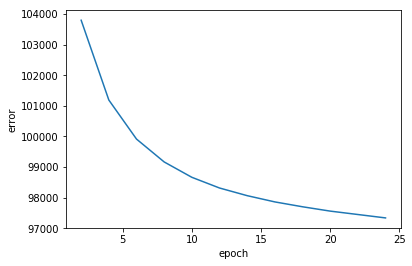

#dims: 402
reduce #dims to 56
svd error: 104708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 28.0713269711 seconds
The error: 108563.0


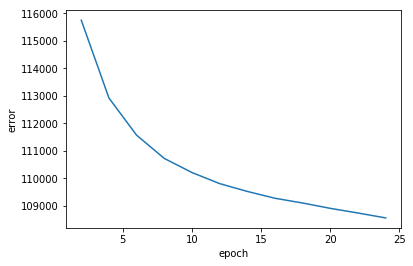

#dims: 458
reduce #dims to 58
svd error: 114799.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 30.631455183 seconds
The error: 119328.0


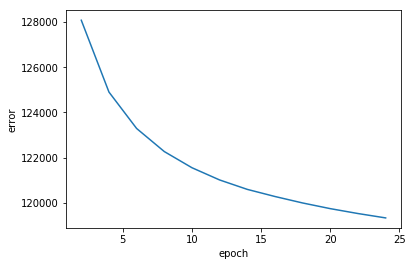

#dims: 522
reduce #dims to 60
svd error: 125318.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 34.8658721447 seconds
The error: 131236.0


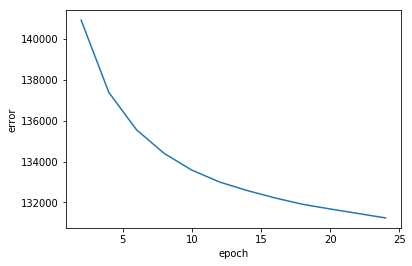

#dims: 595
reduce #dims to 62
svd error: 138381.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 39.556607008 seconds
The error: 146049.0


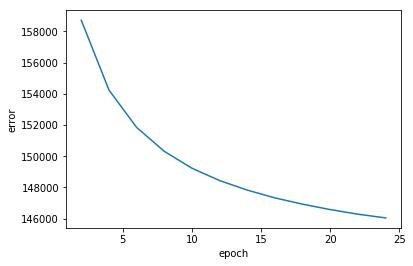

#dims: 679
reduce #dims to 64
svd error: 151308.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 46.3261358738 seconds
The error: 160992.0


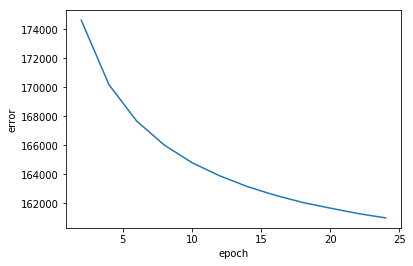

#dims: 775
reduce #dims to 66
svd error: 165031.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 48.1175711155 seconds
The error: 176837.0


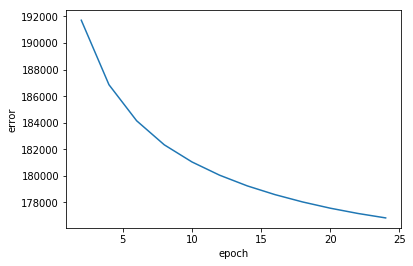

#dims: 884
reduce #dims to 68
svd error: 181194.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 54.7420420647 seconds
The error: 196302.0


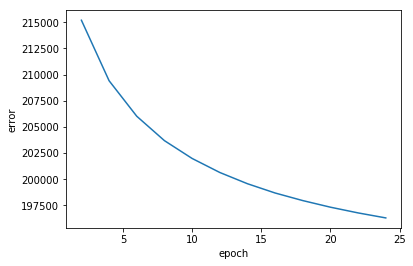

#dims: 1009
reduce #dims to 70
svd error: 196638.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 62.1714129448 seconds
The error: 216068.0


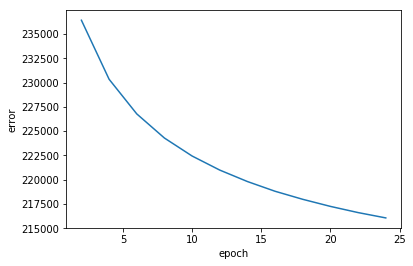

#dims: 1151
reduce #dims to 72
svd error: 212816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 70.4425230026 seconds
The error: 236733.0


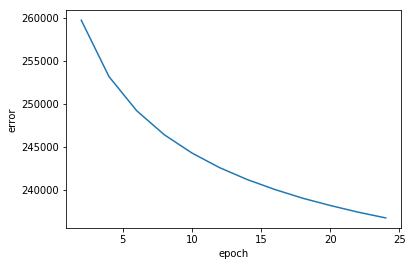

#dims: 1314
reduce #dims to 74
svd error: 229402.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 82.7104279995 seconds
The error: 259859.0


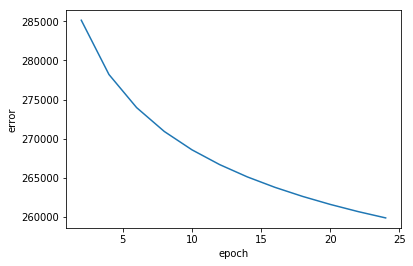

#dims: 1500
reduce #dims to 76
svd error: 247765.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 94.5401699543 seconds
The error: 285301.0


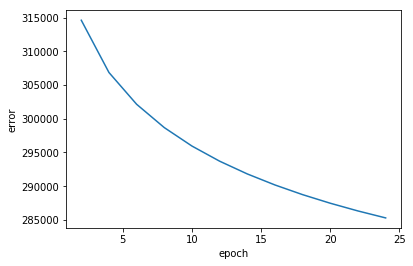

#dims: 1712
reduce #dims to 78
svd error: 267604.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 107.199208975 seconds
The error: 313957.0


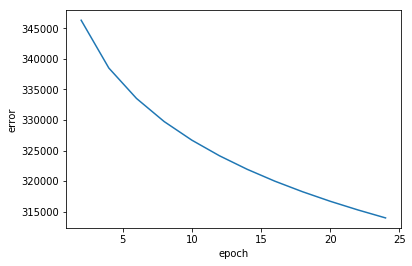

#dims: 1954
reduce #dims to 80
svd error: 288534.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 126.454988003 seconds
The error: 343665.0


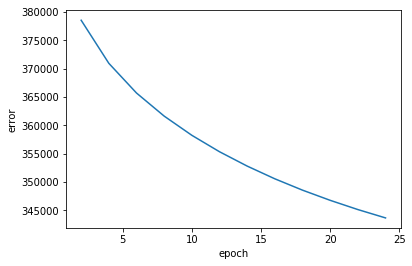

#dims: 2230
reduce #dims to 82
svd error: 310099.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 145.920988083 seconds
The error: 375500.0


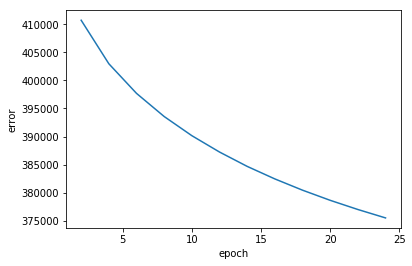

#dims: 2545
reduce #dims to 84
svd error: 333507.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 167.008342028 seconds
The error: 414370.0


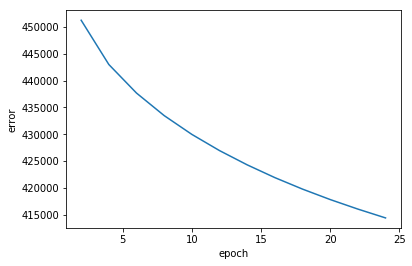

#dims: 2905
reduce #dims to 86
svd error: 358536.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 192.979897022 seconds
The error: 455739.0


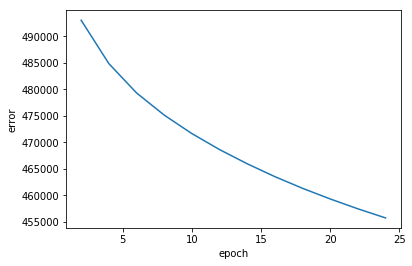

#dims: 3316
reduce #dims to 88
svd error: 384816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 235.047395229 seconds
The error: 500392.0


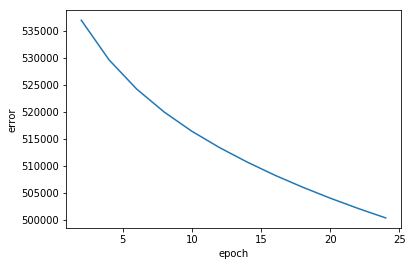

#dims: 3785
reduce #dims to 90
svd error: 414046.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 251.991185188 seconds
The error: 551156.0


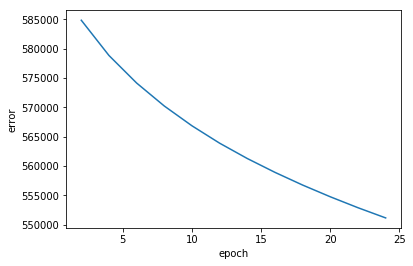

#dims: 4321
reduce #dims to 92
svd error: 443092.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 295.78944993 seconds
The error: 602087.0


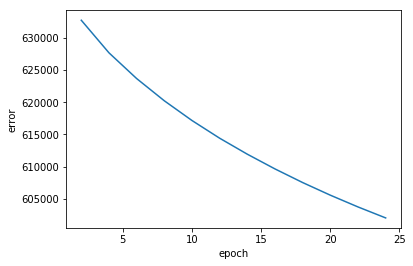

#dims: 4932
reduce #dims to 94
svd error: 473047.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 337.044671059 seconds
The error: 654685.0


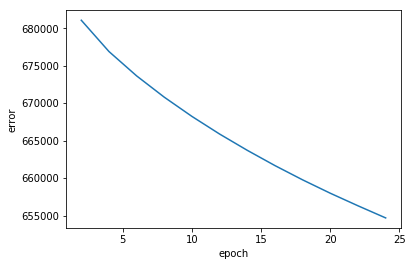

#dims: 5630
reduce #dims to 96
svd error: 507399.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 370.3117311 seconds
The error: 712108.0


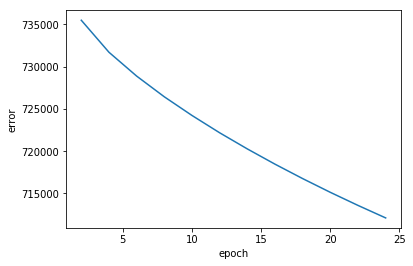

#dims: 6427
reduce #dims to 98
svd error: 549188.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 447.086448908 seconds
The error: 785009.0


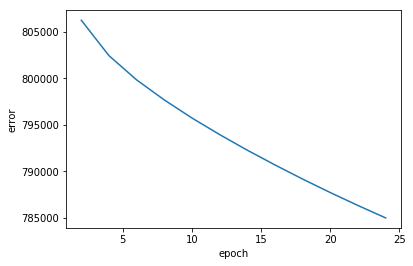

#dims: 7337
reduce #dims to 100
svd error: 584708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 500.328689098 seconds
The error: 843839.0


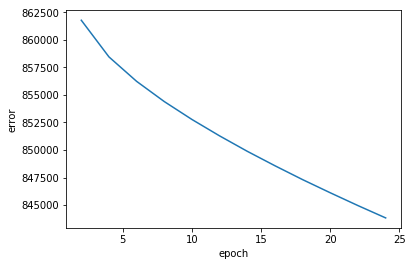

In [31]:
train_cl(8000, 100, 25, num_incs=40, learning_rate=16.0, lr_inc=1)

In [ ]:
pref_matrix = [[0.9, 0.1], [0.1, 0.9]]
block_sizes = [70, 30]
g = ig.Graph.SBM(100, pref_matrix, block_sizes, directed=True)
sim_spm = g.get_adjacency()